# 1. Data Pre-Processing

## a. To import dataset


*  The dataset from Kaggle is saved to google drive.
*  Data source: https://www.kaggle.com/datasets/dragonduck/property-listings-in-kuala-lumpur


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the dataset into a DataFrame
df_property = pd.read_csv(dataset_file_path)

# lower the location to avoid case sensitivity
df_property['Location'] = df_property['Location'].str.lower()

# Display the first few rows of the DataFrame
print(df_property.head())

                          Location         Price Rooms  Bathrooms  Car Parks  \
0               klcc, kuala lumpur  RM 1,250,000   2+1        3.0        2.0   
1  damansara heights, kuala lumpur  RM 6,800,000     6        7.0        NaN   
2            dutamas, kuala lumpur  RM 1,030,000     3        4.0        2.0   
3             cheras, kuala lumpur           NaN   NaN        NaN        NaN   
4        bukit jalil, kuala lumpur    RM 900,000   4+1        3.0        2.0   

          Property Type                      Size        Furnishing  
0    Serviced Residence  Built-up : 1,335 sq. ft.   Fully Furnished  
1              Bungalow  Land area : 6900 sq. ft.  Partly Furnished  
2  Condominium (Corner)  Built-up : 1,875 sq. ft.  Partly Furnished  
3                   NaN                       NaN               NaN  
4  Condominium (Corner)  Built-up : 1,513 sq. ft.  Partly Furnished  


In [ ]:
df_property.shape

(53883, 8)

In [ ]:
# Check for duplicates
duplicates = df_property.duplicated()

print(df_property[duplicates])

                                              Location         Price   Rooms  \
38                                cheras, kuala lumpur           NaN     NaN   
54                   taman tun dr ismail, kuala lumpur           NaN     NaN   
99                                cheras, kuala lumpur           NaN     NaN   
102                               cheras, kuala lumpur           NaN     NaN   
103                          bukit jalil, kuala lumpur    RM 900,000     4+1   
...                                                ...           ...     ...   
53816  jalan klang lama (old klang road), kuala lumpur    RM 520,000       3   
53824                       sri hartamas, kuala lumpur  RM 3,800,000     5+1   
53844                       sri hartamas, kuala lumpur    RM 430,000  Studio   
53848                         sunway spk, kuala lumpur  RM 3,100,000     5+1   
53859                        kuchai lama, kuala lumpur    RM 300,000       3   

       Bathrooms  Car Parks            

## b. Data Construct



*   To enrich the dataseet with more meaningful data, such as nearby train station, schools and malls using Google APi



In [ ]:
!pip install googlemaps

  Preparing metadata (setup.py) ... done
  Created wheel for googlemaps: filename=googlemaps-4.10.0-py3-none-any.whl size=40715 sha256=a9d026865b328afc58aaf44ce33087d01fd7a7dbf662c03dd04d052a7b86ef52
  Stored in directory: /root/.cache/pip/wheels/17/f8/79/999d5d37118fd35d7219ef57933eb9d09886c4c4503a800f84
Successfully built googlemaps


In [ ]:
import pandas as pd
import time
import googlemaps
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb
from google.colab import drive, files
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from multiprocessing import Pool
from geopy.distance import geodesic
from matplotlib.ticker import ScalarFormatter
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, StratifiedKFold
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_iris

In [ ]:
import pandas as pd
import time
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

# Fetch unique locations
unique_locations = df_property['Location'].unique()

# Define the function to get location coordinates with retry logic
def get_location_coordinates(location):
    geolocator = Nominatim(user_agent="geo_coder")  # Initialize geocoder

    max_attempts = 3
    attempt = 1
    while attempt <= max_attempts:
        try:
            location_data = geolocator.geocode(location)
            if location_data:
                return (location_data.latitude, location_data.longitude)
            else:
                print(f"Location not found: {location}")
                return None
        except GeocoderTimedOut:
            print(f"Timed out. Retrying {attempt}/{max_attempts} for {location}...")
            attempt += 1
            time.sleep(1)  # Wait before retrying

    print(f"Failed to retrieve coordinates for {location}.")
    return None

# Process all locations sequentially with a delay
results = []
for location in unique_locations:
    coordinates = get_location_coordinates(location)
    if coordinates:
        results.append((location, coordinates))
    time.sleep(1)  # Respect Nominatim rate limits (1 request per second)

# Convert results to a DataFrame
df_location_coordinates = pd.DataFrame(results, columns=['Location', 'Coordinates'])

# Display the updated DataFrame
print(df_location_coordinates)


Location not found: bukit tunku (kenny hills), kuala lumpur


Location not found: adiva desa parkcity, kuala lumpur
Location not found: bandar damai perdana, kuala lumpur
Location not found: the mines resort, kuala lumpur
Location not found: sri kembangan, kuala lumpur


Location not found: taman tijani ukay, kuala lumpur
Location not found: taman tar, kuala lumpur
Location not found: off gasing indah,, kuala lumpur
Location not found: landed sd, kuala lumpur
Location not found: taman wangsa permai, kuala lumpur
Location not found: kota damansara, kuala lumpur
Location not found: ukay heights, kuala lumpur
Location not found: bandar sri damansara, kuala lumpur
Location not found: cyberjaya, kuala lumpur
Location not found: taman yarl, uog, kuala lumpur
Location not found: kemensah, kuala lumpur
Location not found: taman sri keramat, kuala lumpur
Location not found: canary residence, kuala lumpur
Location not found: taming jaya, kuala lumpur
                           Location                               Coordinates
0                klcc, kuala lumpur                  (3.1593097, 101.7133583)
1   damansara heights, kuala lumpur                  (3.1523954, 101.6584455)
2             dutamas, kuala lumpur          (3.18479585, 101.66850371888108)
3    

In [ ]:
# List of locations not found
locations_not_found = [
    "bukit tunku (kenny hills), kuala lumpur",
    "adiva desa parkcity, kuala lumpur",
    "bandar damai perdana, kuala lumpur",
    "taman tijani ukay, kuala lumpur",
    "taman tar, kuala lumpur",
    "off gasing indah,, kuala lumpur",
    "the mines resort, kuala lumpur",
    "landed sd, kuala lumpur",
    "sri kembangan, kuala lumpur",
    "taman wangsa permai, kuala lumpur",
    "kota damansara, kuala lumpur",
    "kemensah, kuala lumpur",
    "ukay heights, kuala lumpur",
    "bandar sri damansara, kuala lumpur",
    "cyberjaya, kuala lumpur",
    "taman yarl, uog, kuala lumpur",
    "taman sri keramat, kuala lumpur",
    "canary residence, kuala lumpur",
    "taming jaya, kuala lumpur"
]

# Convert the list to a DataFrame
df_locations_not_found = pd.DataFrame(locations_not_found, columns=['Location'])

df_locations_not_found['NEWLocation'] = df_locations_not_found['Location'].apply(lambda x: x.split(',')[0])

# Retry geocoding for modified locations
df_locations_not_found['Coordinates'] = df_locations_not_found['NEWLocation'].apply(get_location_coordinates)

# Drop the 'NEWLocation' column
df_locations_not_found.drop(columns=['NEWLocation'], inplace=True)

# Drop any rows with None values
df_locations_not_found.dropna(inplace=True)

# Display the DataFrame with coordinates
print(df_locations_not_found)

Location not found: adiva desa parkcity
Location not found: taman tijani ukay
Location not found: off gasing indah
Location not found: landed sd
                                   Location  \
0   bukit tunku (kenny hills), kuala lumpur   
2        bandar damai perdana, kuala lumpur   
4                   taman tar, kuala lumpur   
6            the mines resort, kuala lumpur   
8               sri kembangan, kuala lumpur   
9         taman wangsa permai, kuala lumpur   
10             kota damansara, kuala lumpur   
11                   kemensah, kuala lumpur   
12               ukay heights, kuala lumpur   
13       bandar sri damansara, kuala lumpur   
14                  cyberjaya, kuala lumpur   
15            taman yarl, uog, kuala lumpur   
16          taman sri keramat, kuala lumpur   
17           canary residence, kuala lumpur   
18                taming jaya, kuala lumpur   

                                 Coordinates  
0            (3.1690079, 101.68109556606359)  
2       

In [ ]:
# Manual mapping with locations
manual_input_mapping = {
    'adiva desa parkcity, kuala lumpur': 'Desa ParkCity',
    'taman tijani ukay, kuala lumpur': 'Ampang',
    'off gasing indah,, kuala lumpur': 'Gasing Indah',
    'landed sd, kuala lumpur': 'bandar sri damansara'
}


# Apply get_location_coordinates to manual_input_mapping values
updated_mapping = [(key, get_location_coordinates(value)) for key, value in manual_input_mapping.items()]

# Filter out locations with None coordinates
updated_mapping = [(location, coordinates) for location, coordinates in updated_mapping if coordinates is not None]

# Convert the list of tuples to a DataFrame
df_updated_mapping = pd.DataFrame(updated_mapping, columns=['Location', 'Coordinates'])

print(df_updated_mapping)

                            Location                       Coordinates
0  adiva desa parkcity, kuala lumpur   (3.1863832, 101.63181560535014)
1    taman tijani ukay, kuala lumpur  (3.15025555, 101.76021009194159)
2    off gasing indah,, kuala lumpur   (3.08739515, 101.6650536882384)
3            landed sd, kuala lumpur          (3.1934939, 101.6127619)


In [ ]:
# Concatenate the DataFrames
df_location = pd.concat([df_location_coordinates, df_locations_not_found, df_updated_mapping])
df_location = df_location.drop_duplicates(subset='Location')


print(df_location)

                             Location                       Coordinates
0                  klcc, kuala lumpur          (3.1593097, 101.7133583)
1     damansara heights, kuala lumpur          (3.1523954, 101.6584455)
2               dutamas, kuala lumpur  (3.18479585, 101.66850371888108)
3                cheras, kuala lumpur          (3.0991919, 101.7374229)
4           bukit jalil, kuala lumpur          (3.0533462, 101.6802937)
..                                ...                               ...
18          taming jaya, kuala lumpur    (3.0245431, 101.7414556200341)
0   adiva desa parkcity, kuala lumpur   (3.1863832, 101.63181560535014)
1     taman tijani ukay, kuala lumpur  (3.15025555, 101.76021009194159)
2     off gasing indah,, kuala lumpur   (3.08739515, 101.6650536882384)
3             landed sd, kuala lumpur          (3.1934939, 101.6127619)

[108 rows x 2 columns]


In [ ]:
df_location.shape

(108, 2)

In [ ]:
!pip install googlemaps

In [ ]:
# WW's personal API Key. Hidden to prevent being charged
import googlemaps
#gmaps = googlemaps.Client(key=)

# Function to find nearest places of specific types
def find_nearest_places(property_coord, place_types):
    nearest_places = {}
    for place_type in place_types:
        if place_type == 'secondary_school':
            radius = 5000
            places = gmaps.places_nearby(location=property_coord, radius=radius, type=place_type, keyword='secondary school')

        elif place_type == 'train_station':
            radius = 5000
            keywords = 'LRT|MRT|KTM|station|monorail|train'
            places = gmaps.places_nearby(location=property_coord, radius=radius, type=place_type, keyword=keywords)

        elif place_type == 'university':
            radius = 5000
            keywords = 'university|college|kolej|universiti'
            places = gmaps.places_nearby(location=property_coord, radius=radius, type=place_type, keyword=keywords)

        else:
            # Use the default radius for other place types
            radius = 5000
            places = gmaps.places_nearby(location=property_coord, radius=radius, type=place_type)

        if places['results']:
            sorted_places = sorted(places['results'], key=lambda x: geodesic(property_coord, (x['geometry']['location']['lat'], x['geometry']['location']['lng'])).kilometers)
            # Get the nearest place
            nearest_place = sorted_places[0]
            place_name = nearest_place['name']
            place_coord = nearest_place['geometry']['location']

            # Calculate distance
            distance = geodesic(property_coord, (place_coord['lat'], place_coord['lng'])).kilometers

            nearest_places[place_type] = (place_name, distance, place_coord)

    return nearest_places


# Define place types
place_types = ['hospital', 'shopping_mall', 'train_station', 'primary_school', 'secondary_school', 'university']

# List to store results
results = []

# Loop through each location in the dataframe
for index, row in df_location.iterrows():
    # Extract location coordinates
    location = row['Location']
    property_coord = row['Coordinates']

    # Find nearest places for each type
    nearest_places = find_nearest_places(property_coord, place_types)

    # Append results to list
    result_row = {'Location': location}
    for place_type, (place_name, distance, place_coord) in nearest_places.items():
        result_row['Nearest ' + place_type.capitalize()] = place_name
        result_row['Distance to ' + place_type.capitalize() + ' (KM)'] = distance
        result_row[place_type.capitalize() + ' Coordinates'] = place_coord

    results.append(result_row)

# Create DataFrame from results
df_results = pd.DataFrame(results)
df_results.head()

,Location,Nearest Hospital,Distance to Hospital (KM),Hospital Coordinates,Nearest Shopping_mall,Distance to Shopping_mall (KM),Shopping_mall Coordinates,Nearest Train_station,Distance to Train_station (KM),Train_station Coordinates,Nearest Primary_school,Distance to Primary_school (KM),Primary_school Coordinates,Nearest Secondary_school,Distance to Secondary_school (KM),Secondary_school Coordinates,Nearest University,Distance to University (KM),University Coordinates
0,"klcc, kuala lumpur",Twin Towers Medical Clinic,0.220062,"{'lat': 3.1577167, 'lng': 101.7121716}",Suria KLCC,0.177000,"{'lat': 3.158248200000001, 'lng': 101.7121664}",Bank Negara,2.301866,"{'lat': 3.1548053, 'lng': 101.6931397}",Primrose Hill International School,0.756787,"{'lat': 3.162277199999999, 'lng': 101.7194936}",Sekolah Menengah Kebangsaan Puteri Wilayah,1.445936,"{'lat': 3.1619523, 'lng': 101.700618}",Kuala Lumpur Metropolitan University College,0.662347,"{'lat': 3.1543442, 'lng': 101.7100256}"
1,"damansara heights, kuala lumpur",Hollywood Slimming,0.635034,"{'lat': 3.1502209, 'lng': 101.6531577}",Plaza Batai,0.471544,"{'lat': 3.1493588, 'lng': 101.661424}",MRT Semantan,0.774981,"{'lat': 3.1510399, 'lng': 101.6652861}",Sekolah Kebangsaan Bukit Damansara,0.553999,"{'lat': 3.156806, 'lng': 101.6560814}",SMK Seri Hartamas,1.408277,"{'lat': 3.1578974, 'lng': 101.647019}",Perdana University,0.883445,"{'lat': 3.153109, 'lng': 101.6663618}"
2,"dutamas, kuala lumpur",Hypoxi Design Your Body,2.744018,"{'lat': 3.163021, 'lng': 101.6566631}",Red Bella - Beauty By HAQ,1.316403,"{'lat': 3.1952102, 'lng': 101.6742417}",KTM,2.106197,"{'lat': 3.202871, 'lng': 101.67448}",SK Segambut,0.342747,"{'lat': 3.1878567, 'lng': 101.6680176}",SMK KIARAMAS,0.904477,"{'lat': 3.1782507, 'lng': 101.6636232}",Northern Kuala Lumpur International College Ke...,1.804420,"{'lat': 3.1908965, 'lng': 101.6534466}"
3,"cheras, kuala lumpur",心医馆中医 Xin Chinese Medical Hall,0.179098,"{'lat': 3.1007083, 'lng': 101.7368568}",ANEKA @EkoCheras Mall,0.560675,"{'lat': 3.0942549, 'lng': 101.7385724}",Salak Selatan,3.600537,"{'lat': 3.0983739, 'lng': 101.7050419}",Sekolah Kebangsaan Taman Midah,0.926361,"{'lat': 3.0954289, 'lng': 101.7299772}",SMS Selangor,2.016326,"{'lat': 3.1036455, 'lng': 101.7198329}",Kolej Tun Dr. Ismail 1,1.101104,"{'lat': 3.1003976, 'lng': 101.72759}"
4,"bukit jalil, kuala lumpur",KLINIK ICON BUKIT JALIL,0.179226,"{'lat': 3.051909999999999, 'lng': 101.6795464}",The Link 2 @ Bukit Jalil,0.110356,"{'lat': 3.0527454, 'lng': 101.679501}",Petaling,4.036546,"{'lat': 3.0860726, 'lng': 101.6642063}",Sekolah Kebangsaan Bukit Jalil,0.784138,"{'lat': 3.05068, 'lng': 101.6868301}",SMK Bukit Jalil,0.748626,"{'lat': 3.0503789, 'lng': 101.6863469}",IMU University - Bukit Jalil Main Campus,1.050873,"{'lat': 3.0597789, 'lng': 101.6872524}"


In [ ]:
# Perform left join on df_property and df_location
merged_df = pd.merge(df_property, df_results, on='Location', how='left')
merged_df2 = pd.merge(merged_df, df_location, on='Location', how='left')

# Drop duplicates based on the 'Location' column
merged_df2.drop_duplicates

# Display the resulting DataFrame
merged_df=merged_df2
merged_df.head()

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing,Nearest Hospital,Distance to Hospital (KM),...,Nearest Primary_school,Distance to Primary_school (KM),Primary_school Coordinates,Nearest Secondary_school,Distance to Secondary_school (KM),Secondary_school Coordinates,Nearest University,Distance to University (KM),University Coordinates,Coordinates
0,"klcc, kuala lumpur","RM 1,250,000",2+1,3.0,2.0,Serviced Residence,"Built-up : 1,335 sq. ft.",Fully Furnished,Twin Towers Medical Clinic,0.220062,...,Primrose Hill International School,0.756787,"{'lat': 3.162277199999999, 'lng': 101.7194936}",Sekolah Menengah Kebangsaan Puteri Wilayah,1.445936,"{'lat': 3.1619523, 'lng': 101.700618}",Kuala Lumpur Metropolitan University College,0.662347,"{'lat': 3.1543442, 'lng': 101.7100256}","(3.1593097, 101.7133583)"
1,"damansara heights, kuala lumpur","RM 6,800,000",6,7.0,NaN,Bungalow,Land area : 6900 sq. ft.,Partly Furnished,Hollywood Slimming,0.635034,...,Sekolah Kebangsaan Bukit Damansara,0.553999,"{'lat': 3.156806, 'lng': 101.6560814}",SMK Seri Hartamas,1.408277,"{'lat': 3.1578974, 'lng': 101.647019}",Perdana University,0.883445,"{'lat': 3.153109, 'lng': 101.6663618}","(3.1523954, 101.6584455)"
2,"dutamas, kuala lumpur","RM 1,030,000",3,4.0,2.0,Condominium (Corner),"Built-up : 1,875 sq. ft.",Partly Furnished,Hypoxi Design Your Body,2.744018,...,SK Segambut,0.342747,"{'lat': 3.1878567, 'lng': 101.6680176}",SMK KIARAMAS,0.904477,"{'lat': 3.1782507, 'lng': 101.6636232}",Northern Kuala Lumpur International College Ke...,1.804420,"{'lat': 3.1908965, 'lng': 101.6534466}","(3.18479585, 101.66850371888108)"
3,"cheras, kuala lumpur",NaN,NaN,NaN,NaN,NaN,NaN,NaN,心医馆中医 Xin Chinese Medical Hall,0.179098,...,Sekolah Kebangsaan Taman Midah,0.926361,"{'lat': 3.0954289, 'lng': 101.7299772}",SMS Selangor,2.016326,"{'lat': 3.1036455, 'lng': 101.7198329}",Kolej Tun Dr. Ismail 1,1.101104,"{'lat': 3.1003976, 'lng': 101.72759}","(3.0991919, 101.7374229)"
4,"bukit jalil, kuala lumpur","RM 900,000",4+1,3.0,2.0,Condominium (Corner),"Built-up : 1,513 sq. ft.",Partly Furnished,KLINIK ICON BUKIT JALIL,0.179226,...,Sekolah Kebangsaan Bukit Jalil,0.784138,"{'lat': 3.05068, 'lng': 101.6868301}",SMK Bukit Jalil,0.748626,"{'lat': 3.0503789, 'lng': 101.6863469}",IMU University - Bukit Jalil Main Campus,1.050873,"{'lat': 3.0597789, 'lng': 101.6872524}","(3.0533462, 101.6802937)"


In [ ]:
merged_df.shape

(53883, 27)

In [ ]:
merged_df.to_csv('finaldataset.csv', index=False)

In [ ]:
merged_df.to_csv('/content/finaldataset.csv', index=False)

## c. Data Cleaning

*   Removal of data errors and outliers.
*   Handling missing data fields.

In [ ]:
print(df[duplicates])

In [ ]:
# Load the dataset into a DataFrame
df_property = pd.read_csv('/content/finaldataset.csv')
df_property.head()

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing,Nearest Hospital,Distance to Hospital (KM),...,Nearest Primary_school,Distance to Primary_school (KM),Primary_school Coordinates,Nearest Secondary_school,Distance to Secondary_school (KM),Secondary_school Coordinates,Nearest University,Distance to University (KM),University Coordinates,Coordinates
0,"klcc, kuala lumpur","RM 1,250,000",2+1,3.0,2.0,Serviced Residence,"Built-up : 1,335 sq. ft.",Fully Furnished,Twin Towers Medical Clinic,0.215085,...,Primrose Hill International School,0.759036,"{'lat': 3.162277199999999, 'lng': 101.7194936}",Sekolah Menengah Kebangsaan Puteri Wilayah,1.448214,"{'lat': 3.1619523, 'lng': 101.700618}",Kuala Lumpur Metropolitan University College,0.657098,"{'lat': 3.1543442, 'lng': 101.7100256}","(3.1592469, 101.7133662)"
1,"damansara heights, kuala lumpur","RM 6,800,000",6,7.0,NaN,Bungalow,Land area : 6900 sq. ft.,Partly Furnished,Hollywood Slimming,0.635034,...,Sekolah Kebangsaan Bukit Damansara,0.553999,"{'lat': 3.156806, 'lng': 101.6560814}",SMK Seri Hartamas,1.408277,"{'lat': 3.1578974, 'lng': 101.647019}",Perdana University,0.883445,"{'lat': 3.153109, 'lng': 101.6663618}","(3.1523954, 101.6584455)"
2,"dutamas, kuala lumpur","RM 1,030,000",3,4.0,2.0,Condominium (Corner),"Built-up : 1,875 sq. ft.",Partly Furnished,Hypoxi Design Your Body,2.744018,...,SK Segambut,0.342747,"{'lat': 3.1878567, 'lng': 101.6680176}",Segambut Secondary School,0.274479,"{'lat': 3.1871356, 'lng': 101.6676791}",Perdana University,3.511937,"{'lat': 3.153109, 'lng': 101.6663618}","(3.18479585, 101.66850371888108)"
3,"cheras, kuala lumpur",NaN,NaN,NaN,NaN,NaN,NaN,NaN,心医馆中医 Xin Chinese Medical Hall,0.179098,...,Sekolah Kebangsaan Taman Midah,0.926361,"{'lat': 3.0954289, 'lng': 101.7299772}",SMS Selangor,2.016326,"{'lat': 3.1036455, 'lng': 101.7198329}",Kolej Tun Dr. Ismail 1,1.101104,"{'lat': 3.1003976, 'lng': 101.72759}","(3.0991919, 101.7374229)"
4,"bukit jalil, kuala lumpur","RM 900,000",4+1,3.0,2.0,Condominium (Corner),"Built-up : 1,513 sq. ft.",Partly Furnished,KLINIK ICON BUKIT JALIL,0.179226,...,Sekolah Kebangsaan Bukit Jalil,0.784138,"{'lat': 3.05068, 'lng': 101.6868301}",SMK Bukit Jalil,0.748626,"{'lat': 3.0503789, 'lng': 101.6863469}",IMU University - Bukit Jalil Main Campus,1.050873,"{'lat': 3.0597789, 'lng': 101.6872524}","(3.0533462, 101.6802937)"


### i) To check on data accuracy

In [ ]:
# Manual check on the Hospital
List_Hospital = df_property['Nearest Hospital'].unique()
print(List_Hospital)

['Twin Towers Medical Clinic' 'Hollywood Slimming'
 'Hypoxi Design Your Body' '心医馆中医 Xin Chinese Medical Hall'
 'KLINIK ICON BUKIT JALIL' 'Dr Guna Gynae Clinic' 'Cardiologist Malaysia'
 'Dr Sharmini Krishnan Women’s Specialist Clinic'
 'Gleneagles Hospital Kuala Lumpur' 'Pusat Rawatan Islam'
 'Global Doctors Hospital' 'Chi Aesthetic Plaza Arkadia'
 'Cengild G. I. Medical Centre' 'Klinik Pergigian Ancasa'
 'Sethara Acupuncture' 'Lourdes Medical Centre'
 'Pusat Rawatan Pancaran Nur' 'KPJ Tawakkal KL Specialist Hospital'
 'Samkkya Integrated Ayurvedic Clinic Bangsar'
 'Columbia Asia Hospital - Setapak' 'ING Medical Card'
 'KMI Taman Desa Medical Centre'
 'Nourish-Tech Chinese Medical Centre 养正中医药诊疗所（Kepong HQ）'
 'Revive Health Sdn Bhd' 'KLINIK AURORA 24 JAM SETAPAK'
 'CC Chang Skin Specialist' 'Kiara Medical Centre' 'NGE Physio' '聚德福医藥中心'
 'Sunway Medical Centre Velocity (SMCV)' 'Premiere Medical Clinic'
 'O3 Lifetron' 'Total Child Education Centre' 'Pusat Dialisis Khidmat'
 'jaya ling at

In [ ]:
List_Trainstation=df_property["Nearest Train_station"].unique()
print(List_Trainstation)

['Nuocean Sdn Bhd' 'MRT Semantan' 'KTM' 'Salak Selatan'
 'Juta Dahlia Resources (M) Sdn Bhd' 'Mutiara Damansara (SBK08)'
 'KL Sentral' 'Bank Negara' 'Kepong Sentral'
 'Stesen Keretapi Kuala Lumpur' 'Taman Wahyu' 'Kuala Lumpur' nan
 'Petaling' 'Bandar Tasik Selatan' 'Asia Jaya' 'Sentul']


In [ ]:
List_Mall=df_property["Nearest Shopping_mall"].unique()
print(List_Mall)

['Suria KLCC' 'Plaza Batai' 'Red Bella - Beauty By HAQ'
 'ANEKA @EkoCheras Mall' 'The Link 2 @ Bukit Jalil'
 'Glo Damansara Shopping Mall' 'UFL Outlet Aeon Midvalley'
 'SL Metali (M) Sdn Bhd SL-6' 'Datum Jelatek Shopping Centre'
 'The Parenthood Sunway Putra Mall' '1 Mont Kiara' 'Plaza Arkadia'
 'Mid Valley City Sdn Bhd'
 'NIMBLE SAWANA MANAGEMENT SDN BHD (MIB GALLERIA SDN BHD)' 'NISAHIJABS HQ'
 'Melawati Mall' 'Central Market'
 'AUTO6000 Food Delivery Bag And Stainless Steel Table Supply'
 'Bangsar Village II' 'Commons KL at Bukit Bintang'
 'Starhill Gallery Sdn Bhd' 'ETI International Holding Sdn. Bhd.'
 'The Waterfront @ ParkCity' 'Afzali Studio Malaysia' 'Myeg Services'
 'AEON Mall Wangsa Maju' 'Lucky Plaza (Bandar Park)' 'Metromall'
 'ATOMY KEPONG HAPPY CENTER' 'BVLGARI The Gardens'
 "Na'Tasha Beauty Studio" 'The Gardens Mall' 'MyTOWN Shopping Centre'
 'Bangsar Shopping Centre' 'Lot 10' '1 Shamelin Mall'
 'Cheras Aquarium Taman Seri Taming, Natural Plant Aquarium'
 "N'SANTHI SDN.B

### ii) To drop irrelvant column

In [ ]:
df= df_property.copy()

In [ ]:
df.drop(columns=['Nearest Hospital','Hospital Coordinates','Nearest Shopping_mall','Shopping_mall Coordinates','Nearest Train_station','Train_station Coordinates','Nearest Primary_school',
                  'Primary_school Coordinates','Nearest Secondary_school','Secondary_school Coordinates','Nearest University','University Coordinates','Coordinates'],inplace = True,axis = 1)

In [ ]:
df.head()

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing,Distance to Hospital (KM),Distance to Shopping_mall (KM),Distance to Train_station (KM),Distance to Primary_school (KM),Distance to Secondary_school (KM),Distance to University (KM)
0,"klcc, kuala lumpur","RM 1,250,000",2+1,3.0,2.0,Serviced Residence,"Built-up : 1,335 sq. ft.",Fully Furnished,0.215085,0.173149,1.268306,0.759036,1.448214,0.657098
1,"damansara heights, kuala lumpur","RM 6,800,000",6,7.0,NaN,Bungalow,Land area : 6900 sq. ft.,Partly Furnished,0.635034,0.471544,0.774981,0.553999,1.408277,0.883445
2,"dutamas, kuala lumpur","RM 1,030,000",3,4.0,2.0,Condominium (Corner),"Built-up : 1,875 sq. ft.",Partly Furnished,2.744018,1.316403,2.106197,0.342747,0.274479,3.511937
3,"cheras, kuala lumpur",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.179098,0.560675,3.600537,0.926361,2.016326,1.101104
4,"bukit jalil, kuala lumpur","RM 900,000",4+1,3.0,2.0,Condominium (Corner),"Built-up : 1,513 sq. ft.",Partly Furnished,0.179226,0.110356,2.515342,0.784138,0.748626,1.050873


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53883 entries, 0 to 53882
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Location                           53883 non-null  object 
 1   Price                              53635 non-null  object 
 2   Rooms                              52177 non-null  object 
 3   Bathrooms                          51870 non-null  float64
 4   Car Parks                          36316 non-null  float64
 5   Property Type                      53858 non-null  object 
 6   Size                               52820 non-null  object 
 7   Furnishing                         46953 non-null  object 
 8   Distance to Hospital (KM)          53883 non-null  float64
 9   Distance to Shopping_mall (KM)     53883 non-null  float64
 10  Distance to Train_station (KM)     53708 non-null  float64
 11  Distance to Primary_school (KM)    53883 non-null  flo

In [ ]:
df.shape

(53883, 14)

### iii) Handle missing values

In [ ]:
# Check for missing values in each column
missing_values = df.isna().sum()

# Print the number of missing values in each column
print(missing_values)

Location                                 0
Price                                  248
Rooms                                 1706
Bathrooms                             2013
Car Parks                            17567
Property Type                           25
Size                                  1063
Furnishing                            6930
Distance to Hospital (KM)                0
Distance to Shopping_mall (KM)           0
Distance to Train_station (KM)         175
Distance to Primary_school (KM)          0
Distance to Secondary_school (KM)        0
Distance to University (KM)              0
dtype: int64


In [ ]:
# remove rows when Price is missing
df.dropna(subset=['Price'], inplace=True)
df.shape

(53635, 14)

In [ ]:
# Fill the missing categorical values with mode
# df['Rooms'].fillna(df['Rooms'].mode().iloc[0], inplace=True)

filtered_df = df[df['Rooms'].isnull()]
filtered_df.head()

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing,Distance to Hospital (KM),Distance to Shopping_mall (KM),Distance to Train_station (KM),Distance to Primary_school (KM),Distance to Secondary_school (KM),Distance to University (KM)
175,"cheras, kuala lumpur","RM 820,000",NaN,4.0,3.0,2-sty Terrace/Link House (Intermediate),Land area : 22x80 sq. ft.,Unfurnished,0.179098,0.560675,3.600537,0.926361,2.016326,1.101104
303,"mont kiara, kuala lumpur","RM 2,230,000",NaN,NaN,3.0,Condominium,"Built-up : 2,973 sq. ft.",NaN,0.431012,0.451312,2.554989,0.198478,1.454466,0.982384
449,"kl eco city, kuala lumpur","RM 1,200,000",NaN,NaN,NaN,Condominium,Built-up : 969 sq. ft.,NaN,0.456569,0.207083,2.241640,0.463162,1.276924,1.555088
511,"ampang, kuala lumpur","RM 1,280,000",NaN,NaN,NaN,Residential Land,Land area : 100000 sq. ft.,NaN,0.363541,0.605259,3.711428,0.636897,0.597054,1.817306
624,"desa parkcity, kuala lumpur","RM 1,330,000",NaN,NaN,2.0,Condominium (Intermediate),"Built-up : 1,292 sq. ft.",Fully Furnished,0.425943,0.354965,2.488489,0.529248,0.893627,2.455500


In [ ]:
def fill_rooms_mode(group):
    if group.notnull().any():  # Check if group has any non-null values
        mode_value = group.mode().iloc[0]
        return group.fillna(mode_value)
    else:
        mode_value = df['Rooms'].mode().iloc[0]  # Compute mode value without considering 'Property_Type' and 'Location'
        return group.fillna(mode_value)

In [ ]:
# Apply the function to fill missing values in 'Rooms' based on both 'Property_Type' and 'Location'
df['Rooms'] = df.groupby(['Property Type', 'Location'])['Rooms'].transform(fill_rooms_mode)


In [ ]:
df.isnull().sum()

,0
Location,0
Price,0
Rooms,0
Bathrooms,1962
Car Parks,17441
Property Type,0
Size,1024
Furnishing,6856
Distance to Hospital (KM),0
Distance to Shopping_mall (KM),0


In [ ]:
checking = df[(df['Location'] == "cheras, kuala lumpur") & (df['Price'] == 'RM 820,000') & (df['Property Type']=="2-sty Terrace/Link House (Intermediate)") & (df['Size']=="Land area : 22x80 sq. ft.")]
checking.head()

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing,Distance to Hospital (KM),Distance to Shopping_mall (KM),Distance to Train_station (KM),Distance to Primary_school (KM),Distance to Secondary_school (KM),Distance to University (KM)
175,"cheras, kuala lumpur","RM 820,000",4,4.0,3.0,2-sty Terrace/Link House (Intermediate),Land area : 22x80 sq. ft.,Unfurnished,0.179098,0.560675,3.600537,0.926361,2.016326,1.101104
9671,"cheras, kuala lumpur","RM 820,000",4,3.0,NaN,2-sty Terrace/Link House (Intermediate),Land area : 22x80 sq. ft.,Unfurnished,0.179098,0.560675,3.600537,0.926361,2.016326,1.101104
12801,"cheras, kuala lumpur","RM 820,000",4,4.0,NaN,2-sty Terrace/Link House (Intermediate),Land area : 22x80 sq. ft.,Partly Furnished,0.179098,0.560675,3.600537,0.926361,2.016326,1.101104


In [ ]:
missing_bathrooms=df[df["Bathrooms"].isna()]
missing_bathrooms.head()

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing,Distance to Hospital (KM),Distance to Shopping_mall (KM),Distance to Train_station (KM),Distance to Primary_school (KM),Distance to Secondary_school (KM),Distance to University (KM)
303,"mont kiara, kuala lumpur","RM 2,230,000",3+1,NaN,3.0,Condominium,"Built-up : 2,973 sq. ft.",NaN,0.431012,0.451312,2.554989,0.198478,1.454466,0.982384
449,"kl eco city, kuala lumpur","RM 1,200,000",1+1,NaN,NaN,Condominium,Built-up : 969 sq. ft.,NaN,0.456569,0.207083,2.241640,0.463162,1.276924,1.555088
509,"klcc, kuala lumpur","RM 1,240,000",1+1,NaN,NaN,Serviced Residence,Built-up : 850 sq. ft.,NaN,0.215085,0.173149,1.268306,0.759036,1.448214,0.657098
511,"ampang, kuala lumpur","RM 1,280,000",3,NaN,NaN,Residential Land,Land area : 100000 sq. ft.,NaN,0.363541,0.605259,3.711428,0.636897,0.597054,1.817306
536,"mont kiara, kuala lumpur","RM 1,950,000",4+1,NaN,3.0,Condominium,"Built-up : 1,832 sq. ft.",Partly Furnished,0.431012,0.451312,2.554989,0.198478,1.454466,0.982384


In [ ]:
# sample
checking = df[(df['Location'] == "mont kiara, kuala lumpur") & (df['Price'] == 'RM 2,230,000') & (df['Property Type']=="Condominium") & (df['Size']=="Built-up : 2,973 sq. ft.")]
checking.head()

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing,Distance to Hospital (KM),Distance to Shopping_mall (KM),Distance to Train_station (KM),Distance to Primary_school (KM),Distance to Secondary_school (KM),Distance to University (KM)
303,"mont kiara, kuala lumpur","RM 2,230,000",3+1,NaN,3.0,Condominium,"Built-up : 2,973 sq. ft.",NaN,0.431012,0.451312,2.554989,0.198478,1.454466,0.982384
596,"mont kiara, kuala lumpur","RM 2,230,000",4+1,5.0,3.0,Condominium,"Built-up : 2,973 sq. ft.",Partly Furnished,0.431012,0.451312,2.554989,0.198478,1.454466,0.982384
31629,"mont kiara, kuala lumpur","RM 2,230,000",4+1,4.0,3.0,Condominium,"Built-up : 2,973 sq. ft.",Unfurnished,0.431012,0.451312,2.554989,0.198478,1.454466,0.982384
50965,"mont kiara, kuala lumpur","RM 2,230,000",4,5.0,3.0,Condominium,"Built-up : 2,973 sq. ft.",Unfurnished,0.431012,0.451312,2.554989,0.198478,1.454466,0.982384


In [ ]:
def fill_Bathrooms_mode(group):
    if group.notnull().any():  # Check if group has any non-null values
        mode_value = group.mode().iloc[0]
        return group.fillna(mode_value)
    else:
        mode_value = df['Bathrooms'].mode().iloc[0]  # Compute mode value without considering 'Property_Type' and 'Location'
        return group.fillna(mode_value)


In [ ]:
# Apply the function to fill missing values in 'Bathrooms' based on both 'Property_Type' and 'Location'
df['Bathrooms'] = df.groupby(['Property Type', 'Location'])['Bathrooms'].transform(fill_Bathrooms_mode)

In [ ]:
df.isnull().sum()

,0
Location,0
Price,0
Rooms,0
Bathrooms,0
Car Parks,17441
Property Type,0
Size,1024
Furnishing,6856
Distance to Hospital (KM),0
Distance to Shopping_mall (KM),0


In [ ]:
missing_carparks=df[df["Car Parks"].isna()]
missing_carparks.head()

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing,Distance to Hospital (KM),Distance to Shopping_mall (KM),Distance to Train_station (KM),Distance to Primary_school (KM),Distance to Secondary_school (KM),Distance to University (KM)
1,"damansara heights, kuala lumpur","RM 6,800,000",6,7.0,NaN,Bungalow,Land area : 6900 sq. ft.,Partly Furnished,0.635034,0.471544,0.774981,0.553999,1.408277,0.883445
11,"taman tun dr ismail, kuala lumpur","RM 1,680,000",4,3.0,NaN,2-sty Terrace/Link House (Intermediate),Land area : 22 x 80 sq. ft.,Partly Furnished,0.376411,0.393463,3.235269,0.407351,0.604745,2.168576
12,"taman tun dr ismail, kuala lumpur","RM 1,700,000",3+1,3.0,NaN,2-sty Terrace/Link House (Intermediate),Land area : 1900 sq. ft.,Partly Furnished,0.376411,0.393463,3.235269,0.407351,0.604745,2.168576
15,"taman tun dr ismail, kuala lumpur","RM 3,100,000",4+1,3.0,NaN,Semi-detached House (Intermediate),Land area : 3600 sq. ft.,Partly Furnished,0.376411,0.393463,3.235269,0.407351,0.604745,2.168576
17,"damansara heights, kuala lumpur","RM 4,500,000",5+1,7.0,NaN,Bungalow (Corner),"Built-up : 4,842 sq. ft.",Partly Furnished,0.635034,0.471544,0.774981,0.553999,1.408277,0.883445


In [ ]:
# sample
checking = df[(df['Location'] == "damansara heights, kuala lumpur") & (df['Price'] == 'RM 6,800,000'	) ]
checking.head()

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing,Distance to Hospital (KM),Distance to Shopping_mall (KM),Distance to Train_station (KM),Distance to Primary_school (KM),Distance to Secondary_school (KM),Distance to University (KM)
1,"damansara heights, kuala lumpur","RM 6,800,000",6,7.0,NaN,Bungalow,Land area : 6900 sq. ft.,Partly Furnished,0.635034,0.471544,0.774981,0.553999,1.408277,0.883445
107,"damansara heights, kuala lumpur","RM 6,800,000",5+2,7.0,NaN,Bungalow,Land area : 7000 sq. ft.,NaN,0.635034,0.471544,0.774981,0.553999,1.408277,0.883445
5728,"damansara heights, kuala lumpur","RM 6,800,000",6,5.0,4.0,Bungalow (Corner),Land area : 6310 sq. ft.,Partly Furnished,0.635034,0.471544,0.774981,0.553999,1.408277,0.883445
6089,"damansara heights, kuala lumpur","RM 6,800,000",6+1,9.0,3.0,Semi-detached House (Intermediate),Land area : 6000 sq. ft.,Partly Furnished,0.635034,0.471544,0.774981,0.553999,1.408277,0.883445
33851,"damansara heights, kuala lumpur","RM 6,800,000",3+1,3.0,4.0,Bungalow (Intermediate),Land area : 5200 sq. ft.,Unfurnished,0.635034,0.471544,0.774981,0.553999,1.408277,0.883445


In [ ]:
def fill_CarParks_mode(group):
    if group.notnull().any():  # Check if group has any non-null values
        mode_value = group.mode().iloc[0]
        return group.fillna(mode_value)
    else:
        mode_value = df['Car Parks'].mode().iloc[0]  # Compute mode value without considering 'Property_Type' and 'Location'
        return group.fillna(mode_value)

In [ ]:
# Apply the function to fill missing values in 'CarPark' based on both 'Property_Type' and 'Location'
df["Car Parks"] = df.groupby(['Property Type', 'Location'])["Car Parks"].transform(fill_CarParks_mode)

In [ ]:
df.isnull().sum()

,0
Location,0
Price,0
Rooms,0
Bathrooms,0
Car Parks,0
Property Type,0
Size,1024
Furnishing,6856
Distance to Hospital (KM),0
Distance to Shopping_mall (KM),0


In [ ]:
# furnishing is depending on the owner, unable to relate by other variables
df.dropna(subset=['Furnishing','Size',], inplace=True)

In [ ]:
# Check
df.isnull().sum()

,0
Location,0
Price,0
Rooms,0
Bathrooms,0
Car Parks,0
Property Type,0
Size,0
Furnishing,0
Distance to Hospital (KM),0
Distance to Shopping_mall (KM),0


In [ ]:
# Some units do not have train nearby, therefore it is showing as missing value.
# To solve this, we will imput this with larger values

large_value = 1000

# Fill missing values in 'Distance_to_Train_station_(KM)' with the large value
df['Distance to Train_station (KM)'].fillna(large_value, inplace=True)

# Print the DataFrame after filling missing values
df.head()

<ipython-input-42-956bcb387faf>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Distance to Train_station (KM)'].fillna(large_value, inplace=True)


,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing,Distance to Hospital (KM),Distance to Shopping_mall (KM),Distance to Train_station (KM),Distance to Primary_school (KM),Distance to Secondary_school (KM),Distance to University (KM)
0,"klcc, kuala lumpur","RM 1,250,000",2+1,3.0,2.0,Serviced Residence,"Built-up : 1,335 sq. ft.",Fully Furnished,0.215085,0.173149,1.268306,0.759036,1.448214,0.657098
1,"damansara heights, kuala lumpur","RM 6,800,000",6,7.0,4.0,Bungalow,Land area : 6900 sq. ft.,Partly Furnished,0.635034,0.471544,0.774981,0.553999,1.408277,0.883445
2,"dutamas, kuala lumpur","RM 1,030,000",3,4.0,2.0,Condominium (Corner),"Built-up : 1,875 sq. ft.",Partly Furnished,2.744018,1.316403,2.106197,0.342747,0.274479,3.511937
4,"bukit jalil, kuala lumpur","RM 900,000",4+1,3.0,2.0,Condominium (Corner),"Built-up : 1,513 sq. ft.",Partly Furnished,0.179226,0.110356,2.515342,0.784138,0.748626,1.050873
5,"taman tun dr ismail, kuala lumpur","RM 5,350,000",4+2,5.0,4.0,Bungalow,Land area : 7200 sq. ft.,Partly Furnished,0.376411,0.393463,3.235269,0.407351,0.604745,2.168576


In [ ]:
df.isnull().sum()

,0
Location,0
Price,0
Rooms,0
Bathrooms,0
Car Parks,0
Property Type,0
Size,0
Furnishing,0
Distance to Hospital (KM),0
Distance to Shopping_mall (KM),0


In [ ]:
df.shape

(46044, 14)

### iv) Clean up the price column (our target variable)

In [ ]:
# function to remove the currency symbol
def remove_currency(currency, value):
    return value.replace(currency, '')

In [ ]:
# remove currency symbol from remaining rows
df['Price'] = df['Price'].apply(lambda x: remove_currency("RM ",x))

In [ ]:
# convert Price column to float
df['Price'] = pd.to_numeric(df['Price'].str.replace(',',''), errors='coerce')
df.head()

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing,Distance to Hospital (KM),Distance to Shopping_mall (KM),Distance to Train_station (KM),Distance to Primary_school (KM),Distance to Secondary_school (KM),Distance to University (KM)
0,"klcc, kuala lumpur",1250000,2+1,3.0,2.0,Serviced Residence,"Built-up : 1,335 sq. ft.",Fully Furnished,0.215085,0.173149,1.268306,0.759036,1.448214,0.657098
1,"damansara heights, kuala lumpur",6800000,6,7.0,4.0,Bungalow,Land area : 6900 sq. ft.,Partly Furnished,0.635034,0.471544,0.774981,0.553999,1.408277,0.883445
2,"dutamas, kuala lumpur",1030000,3,4.0,2.0,Condominium (Corner),"Built-up : 1,875 sq. ft.",Partly Furnished,2.744018,1.316403,2.106197,0.342747,0.274479,3.511937
4,"bukit jalil, kuala lumpur",900000,4+1,3.0,2.0,Condominium (Corner),"Built-up : 1,513 sq. ft.",Partly Furnished,0.179226,0.110356,2.515342,0.784138,0.748626,1.050873
5,"taman tun dr ismail, kuala lumpur",5350000,4+2,5.0,4.0,Bungalow,Land area : 7200 sq. ft.,Partly Furnished,0.376411,0.393463,3.235269,0.407351,0.604745,2.168576


v) Clean up room variable

In [ ]:
df['Rooms'].value_counts().sort_index()

,count
Rooms,
1,2146
1+1,1064
1+2,5
10,25
10+,7
10+1,5
11,4
11+1,3
12,7


In [ ]:
df['Rooms'] = df['Rooms'].str.replace('20 Above','20+').str.replace('Studio','1')

In [ ]:
df = df[~df.Rooms.str.endswith('+')]

In [ ]:
#apply the functions
df['Rooms'] = df['Rooms'].apply(lambda x: eval(str(x)))

In [ ]:
df['Rooms'].value_counts().sort_index()

,count
Rooms,
1,2941
2,5816
3,14011
4,11692
5,6169
6,3383
7,1413
8,312
9,96


### v) Clean up 'Size' column

In [ ]:
# split the Size column into size types and size
df[['Size_type','Size']] = df['Size'].str.split(':',expand=True)
df.head()

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing,Distance to Hospital (KM),Distance to Shopping_mall (KM),Distance to Train_station (KM),Distance to Primary_school (KM),Distance to Secondary_school (KM),Distance to University (KM),Size_type
0,"klcc, kuala lumpur",1250000,3,3.0,2.0,Serviced Residence,"1,335 sq. ft.",Fully Furnished,0.215085,0.173149,1.268306,0.759036,1.448214,0.657098,Built-up
1,"damansara heights, kuala lumpur",6800000,6,7.0,4.0,Bungalow,6900 sq. ft.,Partly Furnished,0.635034,0.471544,0.774981,0.553999,1.408277,0.883445,Land area
2,"dutamas, kuala lumpur",1030000,3,4.0,2.0,Condominium (Corner),"1,875 sq. ft.",Partly Furnished,2.744018,1.316403,2.106197,0.342747,0.274479,3.511937,Built-up
4,"bukit jalil, kuala lumpur",900000,5,3.0,2.0,Condominium (Corner),"1,513 sq. ft.",Partly Furnished,0.179226,0.110356,2.515342,0.784138,0.748626,1.050873,Built-up
5,"taman tun dr ismail, kuala lumpur",5350000,6,5.0,4.0,Bungalow,7200 sq. ft.,Partly Furnished,0.376411,0.393463,3.235269,0.407351,0.604745,2.168576,Land area


In [ ]:
df['Size_type'].value_counts()

,count
Size_type,
Built-up,33329
Land area,12566


In [ ]:
# show records with no numeric
df[~df.Size.str.contains(r'\d')].head()

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing,Distance to Hospital (KM),Distance to Shopping_mall (KM),Distance to Train_station (KM),Distance to Primary_school (KM),Distance to Secondary_school (KM),Distance to University (KM),Size_type
996,"desa parkcity, kuala lumpur",3880000,6,6.0,2.0,3-sty Terrace/Link House,Kuala Lumpur sq. ft.,Partly Furnished,0.425943,0.354965,2.488489,0.529248,0.893627,2.455500,Land area
1006,"desa parkcity, kuala lumpur",1800000,4,3.0,2.0,Condominium,Kuala Lumpur sq. ft.,Partly Furnished,0.425943,0.354965,2.488489,0.529248,0.893627,2.455500,Land area
1183,"desa parkcity, kuala lumpur",2800000,4,4.0,2.0,3-sty Terrace/Link House (Intermediate),Kuala Lumpur sq. ft.,Partly Furnished,0.425943,0.354965,2.488489,0.529248,0.893627,2.455500,Land area
3319,"klcc, kuala lumpur",1400000,1,1.0,1.0,Serviced Residence (Intermediate),- sq. ft.,Partly Furnished,0.215085,0.173149,1.268306,0.759036,1.448214,0.657098,Land area
3400,"mont kiara, kuala lumpur",2650000,5,5.0,3.0,Condominium (Corner),- sq. ft.,Partly Furnished,0.431012,0.451312,2.554989,0.198478,1.454466,0.982384,Land area


In [ ]:
df[~df.Size.str.contains(r'\d')].shape

(46, 15)

In [ ]:
# remove rows from Size that do not contain any digits
df = df[df.Size.str.contains(r'\d')]

In [ ]:
clean_up_list = ["-","\+",'\'','\~',"acre","#",'xx']

# remove rows from Size that contain substrings from the clean_up_list
for string in clean_up_list:
  df = df[~df.Size.str.contains(string,na=False)]

In [ ]:
# lowercase values in the Size column
df['Size'] = df['Size'].str.lower()

In [ ]:
# replace extraneous characters so that all Size entries are either numeric or of the form "numerica * numericb"
df['Size'] = df['Size'].str.replace("x ","*").str.replace(" x","*").str.replace("x","*").str.replace("X","*").str.replace("~","*").str.replace('@','').str.replace('`','')
df['Size'] = df['Size'].str.replace(',','').str.replace(' sq. ft.','').str.replace(' or 22x75','').str.replace(' or 22x72','').str.replace(' or 45x90','').str.replace(' or 20x60','').str.replace(' or 18x60','').str.replace(' sq','').str.replace("'",'').str.replace('ft','').str.replace('sf','')
df.head()

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing,Distance to Hospital (KM),Distance to Shopping_mall (KM),Distance to Train_station (KM),Distance to Primary_school (KM),Distance to Secondary_school (KM),Distance to University (KM),Size_type
0,"klcc, kuala lumpur",1250000,3,3.0,2.0,Serviced Residence,1335,Fully Furnished,0.215085,0.173149,1.268306,0.759036,1.448214,0.657098,Built-up
1,"damansara heights, kuala lumpur",6800000,6,7.0,4.0,Bungalow,6900,Partly Furnished,0.635034,0.471544,0.774981,0.553999,1.408277,0.883445,Land area
2,"dutamas, kuala lumpur",1030000,3,4.0,2.0,Condominium (Corner),1875,Partly Furnished,2.744018,1.316403,2.106197,0.342747,0.274479,3.511937,Built-up
4,"bukit jalil, kuala lumpur",900000,5,3.0,2.0,Condominium (Corner),1513,Partly Furnished,0.179226,0.110356,2.515342,0.784138,0.748626,1.050873,Built-up
5,"taman tun dr ismail, kuala lumpur",5350000,6,5.0,4.0,Bungalow,7200,Partly Furnished,0.376411,0.393463,3.235269,0.407351,0.604745,2.168576,Land area


In [ ]:
df['Size'].value_counts()

,count
Size,
22*75,602
1100,517
950,466
1200,377
22*80,376
...,...
25 *70,1
11280,1
24 *85,1


In [ ]:
# Function convert sq. m. to sq. ft.
def convert_to_sq_ft(value):
    # Check if the value contains "sq. m."
    if "sq. m." in value:
        # Extract the numeric value
        numeric_value = float(''.join(filter(str.isdigit, value)))
        # Convert to square feet and return
        return numeric_value * 10.764
    else:
        # Return the value as it is
        return value

In [ ]:
# remove extraneous characters following spaces
df['Size'] = df['Size'].apply(lambda x: convert_to_sq_ft(x))

In [ ]:
import re

# function to remove everything after the space in a string
def remove_after_space(input_string):
    # remove leading and trailing spaces
    input_string = input_string.strip()
    #print('input:', input_string)
    # remove everything after internal spaces
    output_string = re.sub(r'\s* .*', '', input_string)
    output_string = re.sub(r'\([^)]*\)','',output_string)
    #print('output:',output_string)
    return(output_string)

In [ ]:
# remove extraneous characters following spaces
df['Size'] = df['Size'].apply(lambda x: remove_after_space(x))

In [ ]:
def remove_second_dot(value):
    first_dot_index = value.find('.')  # Find the index of the first occurrence of '.'
    second_dot_index = value.find('.', first_dot_index + 1)  # Find the index of the second occurrence of '.' after the first one

    if second_dot_index != -1:  # Check if the second '.' exists
        modified_value = value[:second_dot_index] + value[second_dot_index + 1:]  # Remove the second '.'
        return modified_value
    else:
        return value  # Return the original value if the second '.' doesn't exist

# Apply the function to the 'Size' column
df['Size'] = df['Size'].apply(remove_second_dot)

In [ ]:
# apply transformation to replace "numerica * numericb" with the result of the multiplication
df['Size'] = df['Size'].apply(lambda x: eval(str(x)))

In [ ]:
df.head()

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing,Distance to Hospital (KM),Distance to Shopping_mall (KM),Distance to Train_station (KM),Distance to Primary_school (KM),Distance to Secondary_school (KM),Distance to University (KM),Size_type
0,"klcc, kuala lumpur",1250000,3,3.0,2.0,Serviced Residence,1335.0,Fully Furnished,0.215085,0.173149,1.268306,0.759036,1.448214,0.657098,Built-up
1,"damansara heights, kuala lumpur",6800000,6,7.0,4.0,Bungalow,6900.0,Partly Furnished,0.635034,0.471544,0.774981,0.553999,1.408277,0.883445,Land area
2,"dutamas, kuala lumpur",1030000,3,4.0,2.0,Condominium (Corner),1875.0,Partly Furnished,2.744018,1.316403,2.106197,0.342747,0.274479,3.511937,Built-up
4,"bukit jalil, kuala lumpur",900000,5,3.0,2.0,Condominium (Corner),1513.0,Partly Furnished,0.179226,0.110356,2.515342,0.784138,0.748626,1.050873,Built-up
5,"taman tun dr ismail, kuala lumpur",5350000,6,5.0,4.0,Bungalow,7200.0,Partly Furnished,0.376411,0.393463,3.235269,0.407351,0.604745,2.168576,Land area


In [ ]:
columns = ['Location', 'Property Type', 'Furnishing']

def val_col(col):
  for i in col:
    print(i, ":", df[i].unique())
    print("\n")

val_col(columns)

Location : ['klcc, kuala lumpur' 'damansara heights, kuala lumpur'
 'dutamas, kuala lumpur' 'bukit jalil, kuala lumpur'
 'taman tun dr ismail, kuala lumpur' 'sri petaling, kuala lumpur'
 'bukit tunku (kenny hills), kuala lumpur' 'mont kiara, kuala lumpur'
 'desa parkcity, kuala lumpur' 'bangsar south, kuala lumpur'
 'ampang hilir, kuala lumpur' 'kepong, kuala lumpur'
 'jalan klang lama (old klang road), kuala lumpur'
 'sungai besi, kuala lumpur' 'kl city, kuala lumpur'
 'kl sentral, kuala lumpur' 'taman melawati, kuala lumpur'
 'setapak, kuala lumpur' 'city centre, kuala lumpur'
 'country heights damansara, kuala lumpur' 'taman desa, kuala lumpur'
 'sentul, kuala lumpur' 'cheras, kuala lumpur' 'bangsar, kuala lumpur'
 'segambut, kuala lumpur' 'wangsa maju, kuala lumpur'
 'batu caves, kuala lumpur' 'ampang, kuala lumpur'
 'sri hartamas, kuala lumpur' 'bukit kiara, kuala lumpur'
 'setiawangsa, kuala lumpur' 'oug, kuala lumpur'
 'bukit bintang, kuala lumpur' 'jalan sultan ismail, kuala lu

### vi) Location clean up

In [ ]:
# Remove Kuala Lumpour
df['Location'] = df['Location'].str.replace(', kuala lumpur','')

In [ ]:
# Mapping the location
location_mapping = {
    'kl city': 'klcc',
    'city centre':'klcc',
    'jalan klang lama (old klang road)': 'kuchai lama',
    'jalan u-thant': 'ampang',
    'u-thant':'ampang',
    'ampang hilir':'ampang',
    'ukay heights':'ampang',
    'kemensah':'ampang',
    'bandar sri damansara':'sri damansara',
    'damansara heights':'bukit damansara',
    'canary residence':'cheras',
    'solaris dutamas': 'mont kiara',
    'dutamas':'mont kiara',
    'adiva desa parkcity':'desa parkcity',
    'duta nusantara':'sri hartamas',
    'bukit tunku (kenny hills)':'bukit tunku',
    'the mines resort': 'sri kembangan',
    'seri kembangan': 'sri kembangan',
    'wangsa melawati':'wangsa maju',
    'casa rimba':'taman melawati',
    'taman yarl oug':'oug',
    'taman yarl, uog':'oug',
    'taman yarl':'oug',
    'taman ibukota':'setapak',
    'taman sri keramat':'keramat',
    'gurney':'keramat',
    'bandar tasik selatan':'sungai besi',
    'jinjang': 'kepong',
    'other':'kuala lumpur'
}

In [ ]:
df['Location'] = df['Location'].map(location_mapping).fillna(df['Location'])

In [ ]:
df['Location'].unique()

array(['klcc', 'bukit damansara', 'mont kiara', 'bukit jalil',
       'taman tun dr ismail', 'sri petaling', 'bukit tunku',
       'desa parkcity', 'bangsar south', 'ampang', 'kepong',
       'kuchai lama', 'sungai besi', 'kl sentral', 'taman melawati',
       'setapak', 'country heights damansara', 'taman desa', 'sentul',
       'cheras', 'bangsar', 'segambut', 'wangsa maju', 'batu caves',
       'sri hartamas', 'bukit kiara', 'setiawangsa', 'oug',
       'bukit bintang', 'jalan sultan ismail', 'chan sow lin',
       'jalan kuching', 'bandar menjalara', 'seputeh', 'sunway spk',
       'kl eco city', 'pantai', 'jalan ipoh', 'mid valley city',
       'desa pandan', 'brickfields', 'pandan indah', 'desa petaling',
       'federal hill', 'pandan perdana', 'bandar damai perdana',
       'puchong', 'keramat', 'salak selatan', 'semarak', 'titiwangsa',
       'damansara', 'alam damai', 'bukit ledang', 'sri kembangan',
       'taman duta', 'happy garden', 'pandan jaya', 'taman tar',
       'sun

### vii) Clean up property type

In [ ]:
def remove_bracket(input_string):
    # remove leading and trailing spaces
    input_string = input_string.strip()
    #print('input:', input_string)
    # remove content within parentheses
    output_string = re.sub(r'\s*\([^)]*\)','',input_string)
    return(output_string)

In [ ]:
# remove content in braket
df['Property Type'] = df['Property Type'].apply(lambda x: remove_bracket(x))

In [ ]:
df['Property Type'].unique()

array(['Serviced Residence', 'Bungalow', 'Condominium',
       'Semi-detached House', '2-sty Terrace/Link House', 'Apartment',
       '3-sty Terrace/Link House', '2.5-sty Terrace/Link House',
       '3.5-sty Terrace/Link House', '1.5-sty Terrace/Link House',
       '1-sty Terrace/Link House', '4-sty Terrace/Link House',
       'Townhouse', '4.5-sty Terrace/Link House', 'Residential Land',
       'Bungalow Land', 'Flat', 'Cluster House'], dtype=object)

### viii) Clean up unknown furnishing

In [ ]:
# Filter the DataFrame to exclude rows where 'Furnishing' is 'Unknown'
df = df[df['Furnishing'] != 'Unknown']

# Reset the index after dropping rows
df.reset_index(drop=True, inplace=True)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45133 entries, 0 to 45132
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Location                           45133 non-null  object 
 1   Price                              45133 non-null  int64  
 2   Rooms                              45133 non-null  int64  
 3   Bathrooms                          45133 non-null  float64
 4   Car Parks                          45133 non-null  float64
 5   Property Type                      45133 non-null  object 
 6   Size                               45133 non-null  float64
 7   Furnishing                         45133 non-null  object 
 8   Distance to Hospital (KM)          45133 non-null  float64
 9   Distance to Shopping_mall (KM)     45133 non-null  float64
 10  Distance to Train_station (KM)     45133 non-null  float64
 11  Distance to Primary_school (KM)    45133 non-null  flo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

df.to_csv('/content/finaldataset_cleaned.csv', index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### iv) Remove duplicates

In [ ]:
dataset_file_path = '/content/drive/MyDrive/WQD7003/finaldataset_cleaned.csv'
df_cont = pd.read_csv(dataset_file_path)
duplicate_count = df_cont.duplicated().sum()
# Remove duplicate rows
df_cont = df_cont.drop_duplicates()

print(df_cont)

                  Location    Price  Rooms  Bathrooms  Car Parks  \
0                     klcc  1250000      3        3.0        2.0   
1          bukit damansara  6800000      6        7.0        4.0   
2               mont kiara  1030000      3        4.0        2.0   
3              bukit jalil   900000      5        3.0        2.0   
4      taman tun dr ismail  5350000      6        5.0        4.0   
...                    ...      ...    ...        ...        ...   
45127           mont kiara  6500000      6        6.0        4.0   
45128              bangsar  5100000      6        4.0        4.0   
45129              bangsar  5000000      5        4.0        4.0   
45130              bangsar  5500000      6        4.0        4.0   
45132              setapak   540000      4        2.0        3.0   

            Property Type     Size        Furnishing  \
0      Serviced Residence   1335.0   Fully Furnished   
1                Bungalow   6900.0  Partly Furnished   
2             C

In [ ]:
df_cont.to_csv('/content/drive/MyDrive/WQD7003/finaldataset_cleaned_v2.csv', index=False)

In [ ]:
df_cont.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38590 entries, 0 to 45132
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Location                           38590 non-null  object 
 1   Price                              38590 non-null  int64  
 2   Rooms                              38590 non-null  int64  
 3   Bathrooms                          38590 non-null  float64
 4   Car Parks                          38590 non-null  float64
 5   Property Type                      38590 non-null  object 
 6   Size                               38590 non-null  float64
 7   Furnishing                         38590 non-null  object 
 8   Distance to Hospital (KM)          38590 non-null  float64
 9   Distance to Shopping_mall (KM)     38590 non-null  float64
 10  Distance to Train_station (KM)     38590 non-null  float64
 11  Distance to Primary_school (KM)    38590 non-null  float64


In [ ]:
import pandas as pd

dataset_url = 'https://drive.google.com/uc?export=download&id=17G6a_ax83yx8HQupIiCexFGxK5PKrBWg'

# Load the dataset into a DataFrame
df1 = pd.read_csv(dataset_url)

# Check the first few rows of the dataset
print(df1.head())


              Location    Price  Rooms  Bathrooms  Car Parks  \
0                 klcc  1250000      3        3.0        2.0   
1      bukit damansara  6800000      6        7.0        4.0   
2           mont kiara  1030000      3        4.0        2.0   
3          bukit jalil   900000      5        3.0        2.0   
4  taman tun dr ismail  5350000      6        5.0        4.0   

        Property Type    Size        Furnishing  Distance to Hospital (KM)  \
0  Serviced Residence  1335.0   Fully Furnished                   0.220062   
1            Bungalow  6900.0  Partly Furnished                   0.635034   
2         Condominium  1875.0  Partly Furnished                   1.360108   
3         Condominium  1513.0  Partly Furnished                   0.179226   
4            Bungalow  7200.0  Partly Furnished                   0.376411   

   Distance to Shopping_mall (KM)  Distance to Train_station (KM)  \
0                        0.177000                        2.301866   
1       

In [ ]:
# Group by 'Location' and count the number of rows for each location
location_counts = df1.groupby('Location').size().reset_index(name='Count')

# Sort the counts in descending order
location_counts = location_counts.sort_values(by='Count', ascending=False)

print(location_counts)


              Location  Count
37          mont kiara   5021
32                klcc   4986
16              cheras   3179
35         kuchai lama   2538
11         bukit jalil   1757
..                 ...    ...
60     taman connaught      1
33      kota damansara      1
45              rawang      1
8   bukit  persekutuan      1
0           alam damai      1

[70 rows x 2 columns]


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38590 entries, 0 to 38589
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Location                           38590 non-null  object 
 1   Price                              38590 non-null  int64  
 2   Rooms                              38590 non-null  int64  
 3   Bathrooms                          38590 non-null  float64
 4   Car Parks                          38590 non-null  float64
 5   Property Type                      38590 non-null  object 
 6   Size                               38590 non-null  float64
 7   Furnishing                         38590 non-null  object 
 8   Distance to Hospital (KM)          38590 non-null  float64
 9   Distance to Shopping_mall (KM)     38590 non-null  float64
 10  Distance to Train_station (KM)     38590 non-null  float64
 11  Distance to Primary_school (KM)    38590 non-null  flo

In [ ]:
df1.describe()

,Price,Rooms,Bathrooms,Car Parks,Size,Distance to Hospital (KM),Distance to Shopping_mall (KM),Distance to Train_station (KM),Distance to Primary_school (KM),Distance to Secondary_school (KM),Distance to University (KM)
count,3.859000e+04,38590.000000,38590.000000,38590.000000,38590.000000,38590.000000,38590.000000,38590.000000,38590.000000,38590.000000,38590.000000
mean,1.888863e+06,3.728557,3.138300,2.076263,2481.674739,0.621061,0.583564,32.718107,0.602390,1.184212,1.800368
std,9.471175e+06,1.501661,1.641058,1.295579,10618.625990,0.552817,0.412717,170.440575,0.327497,0.538009,0.928496
min,3.300000e+02,1.000000,1.000000,1.000000,0.000000,0.034223,0.060604,0.036777,0.056436,0.205750,0.150098
25%,6.000000e+05,3.000000,2.000000,1.000000,1023.000000,0.220062,0.299867,2.148585,0.339433,0.748626,1.050873
50%,1.030000e+06,4.000000,3.000000,2.000000,1440.000000,0.431012,0.471544,2.554989,0.635004,1.240248,1.998213
75%,2.055540e+06,5.000000,4.000000,2.000000,2443.000000,0.753757,0.837595,3.600537,0.784138,1.454466,2.446332
max,1.600000e+09,18.000000,20.000000,30.000000,820000.000000,3.218528,2.528700,1000.000000,2.764377,3.311184,3.958932


In [ ]:
import pandas as pd
import time
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb
from google.colab import drive, files
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from multiprocessing import Pool
from geopy.distance import geodesic
from matplotlib.ticker import ScalarFormatter
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, StratifiedKFold
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_iris

# 2. Exploratory Data Analysis

### a. Remove outliers

#### Price

In [ ]:
# Set pandas to display numbers without scientific notation
pd.set_option('display.float_format', '{:,.0f}'.format)


summary_stats = df1['Price'].describe()
print(summary_stats)


count          38,590
mean        1,888,863
std         9,471,175
min               330
25%           600,000
50%         1,030,000
75%         2,055,540
max     1,600,000,000
Name: Price, dtype: float64


In [ ]:
# Set a minimum price threshold
df1 = df1[df1['Price'] >= 100000]

# Show the cleaned summary statistics
summary_stats_cleaned = df1['Price'].describe()
print(summary_stats_cleaned)


count          38,296
mean        1,903,332
std         9,506,017
min           105,000
25%           613,700
50%         1,050,000
75%         2,100,000
max     1,600,000,000
Name: Price, dtype: float64


In [ ]:

# Calculate quartiles
quartiles = df1['Price'].quantile([0, 0.25, 0.5, 0.75, 1])

# Create a DataFrame to display quartiles
quartile_table = pd.DataFrame({'Quartiles': quartiles})

# Add quartile labels
quartile_table.index = ['Min', 'Q1 (25th Percentile)', 'Median (50th Percentile)', 'Q3 (75th Percentile)', 'Max']

# Convert DataFrame to string with custom formatting to avoid scientific notation
quartile_table_str = quartile_table.to_string(float_format=lambda x: '%.2f' % x)

# Display the quartile table
print(quartile_table_str)


                             Quartiles
Min                          105000.00
Q1 (25th Percentile)         613700.00
Median (50th Percentile)    1050000.00
Q3 (75th Percentile)        2100000.00
Max                      1600000000.00


<ipython-input-90-8177e8403983>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['G_Price'] = pd.cut(df1['Price'], bins=price_bins, labels=price_labels, right=False)


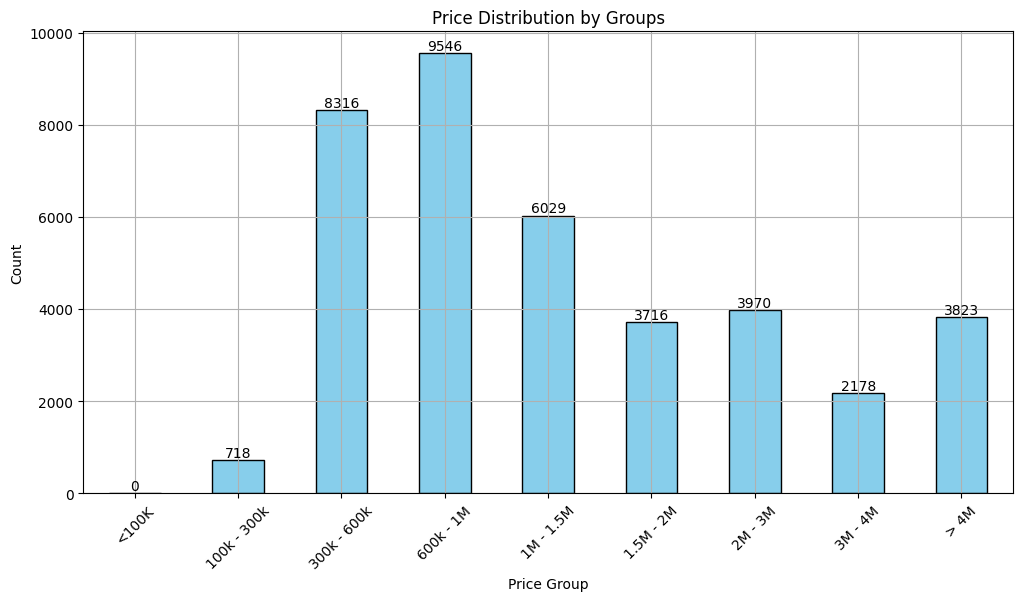

In [ ]:
# Define the price groups
price_bins = [0, 100000,300000, 600000, 1000000, 1500000, 2000000, 3000000, 4000000, float('inf')]
price_labels = ['<100K','100k - 300k', '300k - 600k', '600k - 1M', '1M - 1.5M', '1.5M - 2M', '2M - 3M', '3M - 4M', '> 4M']

# Group prices into categories
df1['G_Price'] = pd.cut(df1['Price'], bins=price_bins, labels=price_labels, right=False)

# Count the occurrences of each price group
price_counts = df1['G_Price'].value_counts().sort_index()

# Plot the chart
plt.figure(figsize=(12, 6))
price_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Price Distribution by Groups')
plt.xlabel('Price Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)

# Add labels for each bar
for i, count in enumerate(price_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()


The majority of properties fall in the 600k–1M and 300k–600k price groups, indicating that mid-range properties dominate the dataset, while properties below 100k are the least common.

In [ ]:
# Filter the DataFrame to include only properties between 300k and 1m
filtered_df = df1[(df1['Price'] >= 300000) & (df1['Price'] <= 1000000)]

# Count the number of properties in this range
count_in_range = len(filtered_df)

# Count the total number of properties
total_count = len(df1)

# Calculate the percentage
percentage_in_range = (count_in_range / total_count) * 100

# Print the percentage
print(f"The percentage of properties between 300k and 1m: {percentage_in_range:.2f}%")


The percentage of properties between 300k and 1m: 47.46%


#### Remove outlier for price

* Calculate the Z-score for the 'Price' column to identify outliers.
* set a threshold of Z-score > 3 to define outliers.
* Outliers are highlighted in red on the scatter plot.



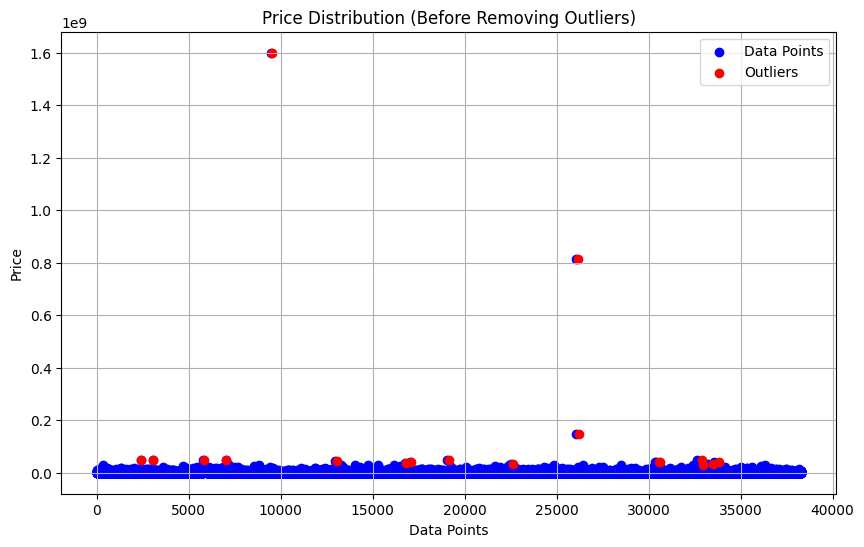

              Location    Price  Rooms  Bathrooms  Car Parks  \
0                 klcc  1250000      3          3          2   
1      bukit damansara  6800000      6          7          4   
2           mont kiara  1030000      3          4          2   
3          bukit jalil   900000      5          3          2   
4  taman tun dr ismail  5350000      6          5          4   

        Property Type  Size        Furnishing  Distance to Hospital (KM)  \
0  Serviced Residence 1,335   Fully Furnished                          0   
1            Bungalow 6,900  Partly Furnished                          1   
2         Condominium 1,875  Partly Furnished                          1   
3         Condominium 1,513  Partly Furnished                          0   
4            Bungalow 7,200  Partly Furnished                          0   

   Distance to Shopping_mall (KM)  Distance to Train_station (KM)  \
0                               0                               2   
1                   

In [ ]:
# Calculate Z-scores for Price
df1['Price_Zscore'] = zscore(df1['Price'])

# Scatter plot of Price before removing outliers
plt.figure(figsize=(10, 6))
plt.scatter(range(len(df1)), df1['Price'], color='blue', label='Data Points')

# Highlight outliers in red
outliers = df1[df1['Price_Zscore'].abs() > 3]
plt.scatter(outliers.index, outliers['Price'], color='red', label='Outliers')

# Customize plot
plt.title('Price Distribution (Before Removing Outliers)')
plt.xlabel('Data Points')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Remove outliers
outliers_removed = df1[df1['Price_Zscore'].abs() <= 3]

# Print the DataFrame after removing outliers
print(outliers_removed.head())


The chart highlights some outliers in the dataset, with a few properties having extremely high prices that distort the overall distribution. We proceed to the next part by removing the outliers.

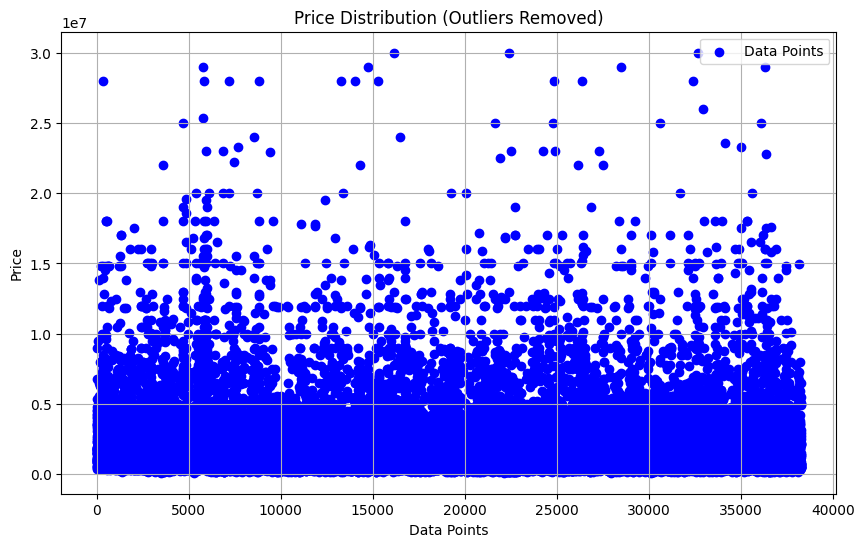

              Location    Price  Rooms  Bathrooms  Car Parks  \
0                 klcc  1250000      3          3          2   
1      bukit damansara  6800000      6          7          4   
2           mont kiara  1030000      3          4          2   
3          bukit jalil   900000      5          3          2   
4  taman tun dr ismail  5350000      6          5          4   

        Property Type  Size        Furnishing  Distance to Hospital (KM)  \
0  Serviced Residence 1,335   Fully Furnished                          0   
1            Bungalow 6,900  Partly Furnished                          1   
2         Condominium 1,875  Partly Furnished                          1   
3         Condominium 1,513  Partly Furnished                          0   
4            Bungalow 7,200  Partly Furnished                          0   

   Distance to Shopping_mall (KM)  Distance to Train_station (KM)  \
0                               0                               2   
1                   

In [ ]:
# Calculate Z-scores for Price
df1['Price_Zscore'] = zscore(df1['Price'])

# Threshold for outlier detection (Z-score > 3)
outliers_removed = df1[df1['Price_Zscore'].abs() <= 3]

# Scatter plot of Price without outliers
plt.figure(figsize=(10, 6))
plt.scatter(range(len(outliers_removed)), outliers_removed['Price'], color='blue', label='Data Points')

# Customize plot
plt.title('Price Distribution (Outliers Removed)')
plt.xlabel('Data Points')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Print the DataFrame after removing outliers
print(outliers_removed.head())


After removing outliers, the price distribution becomes more compact and clearer, showing that most property prices fall within a reasonable range, with fewer extreme values.

In [ ]:
# Drop the outlier
df1['Price_Zscore'] = zscore(df1['Price'])

# Threshold for outlier detection (Z-score > 3)
outliers = df1[df1['Price_Zscore'].abs() > 3]

# Remove outliers from the DataFrame
df1 = df1[df1['Price_Zscore'].abs() <= 3]

# Drop the 'Price_Zscore' column
df1.drop(columns=['Price_Zscore'], inplace=True)

<ipython-input-94-d535eac0b822>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.drop(columns=['Price_Zscore'], inplace=True)


In [ ]:
# Calculate Z-scores for Price
df1['Price_Zscore'] = zscore(df1['Price'])

# Filter out outliers
df1_no_outliers = df1[df1['Price_Zscore'].abs() <= 3]

# Drop the 'Price_Zscore' column as it's no longer needed
df1_no_outliers = df1_no_outliers.drop(columns=['Price_Zscore'])

# Display the DataFrame after removing outliers
print(df1_no_outliers.head())


              Location    Price  Rooms  Bathrooms  Car Parks  \
0                 klcc  1250000      3          3          2   
1      bukit damansara  6800000      6          7          4   
2           mont kiara  1030000      3          4          2   
3          bukit jalil   900000      5          3          2   
4  taman tun dr ismail  5350000      6          5          4   

        Property Type  Size        Furnishing  Distance to Hospital (KM)  \
0  Serviced Residence 1,335   Fully Furnished                          0   
1            Bungalow 6,900  Partly Furnished                          1   
2         Condominium 1,875  Partly Furnished                          1   
3         Condominium 1,513  Partly Furnished                          0   
4            Bungalow 7,200  Partly Furnished                          0   

   Distance to Shopping_mall (KM)  Distance to Train_station (KM)  \
0                               0                               2   
1                   

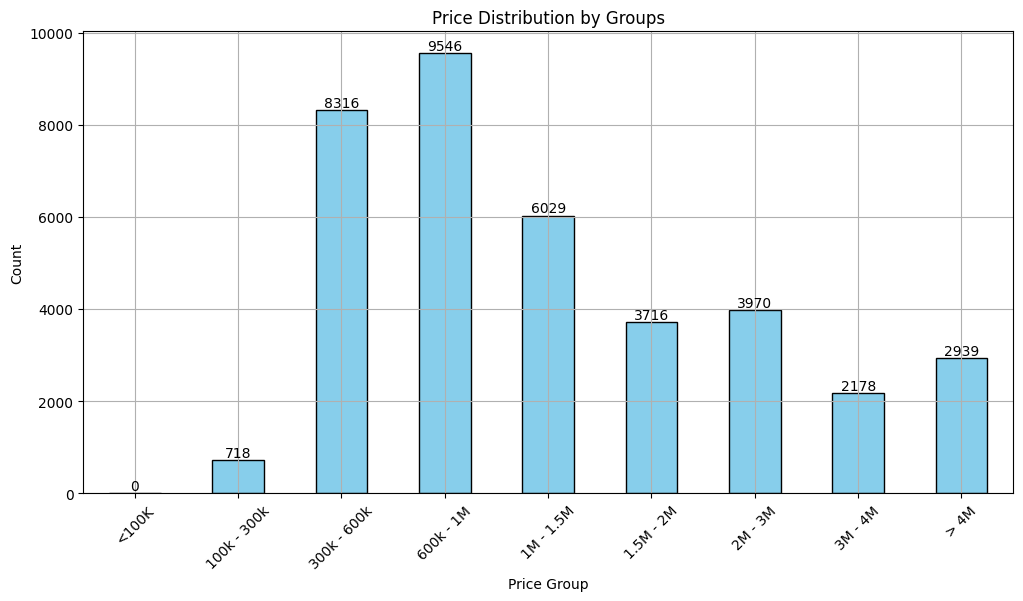

In [ ]:
df1_no_outliers['G_Price'] = pd.cut(df1_no_outliers['Price'], bins=price_bins, labels=price_labels, right=False)

# Count the occurrences of each price group
price_counts = df1_no_outliers['G_Price'].value_counts().sort_index()

# Plot the chart
plt.figure(figsize=(12, 6))
price_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Price Distribution by Groups')
plt.xlabel('Price Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)

# Add labels for each bar
for i, count in enumerate(price_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

Chart shows that majority of properties are priced between 300k–1M, with a significant drop in counts for both lower-priced (<100k) and higher-priced (>3M) categories.

In [ ]:
# Rename df1_no_outliers
df1= df1_no_outliers.copy()

df1.shape
df1 = df1.drop(columns=['G_Price'])

#### Size

In [ ]:
# Define the bins and labels for g_size
bins = [0, 400, 600, 1000, float('inf')]
labels = ['a.<400', 'b.400 - 600', 'c.600 - 1000', 'd.> 1000']

# Create the g_size column based on the Size values
df1['g_size'] = pd.cut(df1['Size'], bins=bins, labels=labels, right=False)

# Display the DataFrame with the new g_size column
print(df1.head())


              Location    Price  Rooms  Bathrooms  Car Parks  \
0                 klcc  1250000      3          3          2   
1      bukit damansara  6800000      6          7          4   
2           mont kiara  1030000      3          4          2   
3          bukit jalil   900000      5          3          2   
4  taman tun dr ismail  5350000      6          5          4   

        Property Type  Size        Furnishing  Distance to Hospital (KM)  \
0  Serviced Residence 1,335   Fully Furnished                          0   
1            Bungalow 6,900  Partly Furnished                          1   
2         Condominium 1,875  Partly Furnished                          1   
3         Condominium 1,513  Partly Furnished                          0   
4            Bungalow 7,200  Partly Furnished                          0   

   Distance to Shopping_mall (KM)  Distance to Train_station (KM)  \
0                               0                               2   
1                   

In [ ]:
# Calculate the counts of each group in the g_size column
g_size_counts = df1['g_size'].value_counts().reset_index()

# Rename the columns for clarity
g_size_counts.columns = ['g_size', 'Count']

# Display the table
print(g_size_counts)


         g_size  Count
0      d.> 1000  28645
1  c.600 - 1000   7418
2   b.400 - 600    809
3        a.<400    540


In [ ]:
# Calculate the counts of each group in the g_size column
g_size_counts = df1['g_size'].value_counts().reset_index()

# Rename the columns for clarity
g_size_counts.columns = ['g_size', 'Count']

# Calculate the average room count in each group
avg_room_count = df1.groupby('g_size')['Rooms'].mean().reset_index()

# Merge the two DataFrames on the 'g_size' column
g_size_counts = g_size_counts.merge(avg_room_count, on='g_size')

# Rename the column for the average room count
g_size_counts.rename(columns={'Rooms': 'Average Room Count'}, inplace=True)

# Display the table
print(g_size_counts)


         g_size  Count  Average Room Count
0      d.> 1000  28645                   4
1  c.600 - 1000   7418                   2
2   b.400 - 600    809                   1
3        a.<400    540                   4


<ipython-input-100-a2ae37e8f2b4>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_room_count = df1.groupby('g_size')['Rooms'].mean().reset_index()


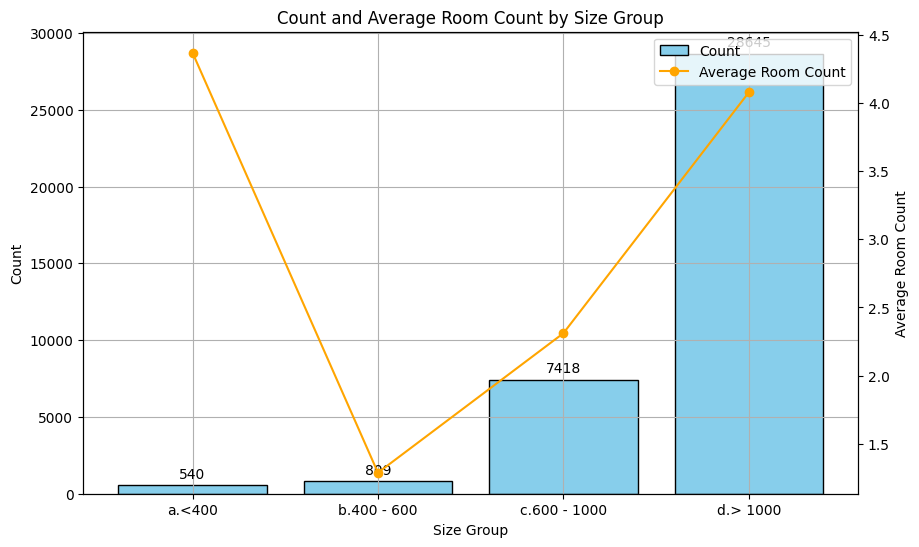

In [ ]:
# Sort the DataFrame by 'g_size' column
g_size_counts_sorted = g_size_counts.sort_values(by='g_size')

# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot bar chart for counts
bars = ax1.bar(g_size_counts_sorted['g_size'], g_size_counts_sorted['Count'], color='skyblue', edgecolor='black', label='Count')

# Set labels and title for the bar plot
ax1.set_xlabel('Size Group')
ax1.set_ylabel('Count')
ax1.set_title('Count and Average Room Count by Size Group')

# Create a secondary axis for the line plot
ax2 = ax1.twinx()

# Plot line chart for average room count
line = ax2.plot(g_size_counts_sorted['g_size'], g_size_counts_sorted['Average Room Count'], marker='o', color='orange', linestyle='-', label='Average Room Count')

# Set labels for the line plot
ax2.set_ylabel('Average Room Count')

# Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Add labels to the bars indicating the count of rooms
for bar in bars:
    height = bar.get_height()
    ax1.annotate('{}'.format(height),
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show gridlines
ax1.grid(True)

# Show the plot
plt.show()


Properties in the >1000 sq ft size group dominate the count, with an average room count of 4, while smaller size groups have significantly lower counts and fewer rooms on average.

In [ ]:
df1 = df1[(df1['Size'] > 400)]

In [ ]:
# Drop the outlier
df1['Rooms_Zscore'] = zscore(df1['Rooms'])

# Threshold for outlier detection (Z-score > 3)
outliers = df1[df1['Rooms_Zscore'].abs() > 3]

# Remove outliers from the DataFrame
df1 = df1[df1['Rooms_Zscore'].abs() <= 3]

# Drop the 'Price_Zscore' column
df1.drop(columns=['Rooms_Zscore'], inplace=True)

<ipython-input-103-095be32b7bc9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Rooms_Zscore'] = zscore(df1['Rooms'])


#### Bathroom

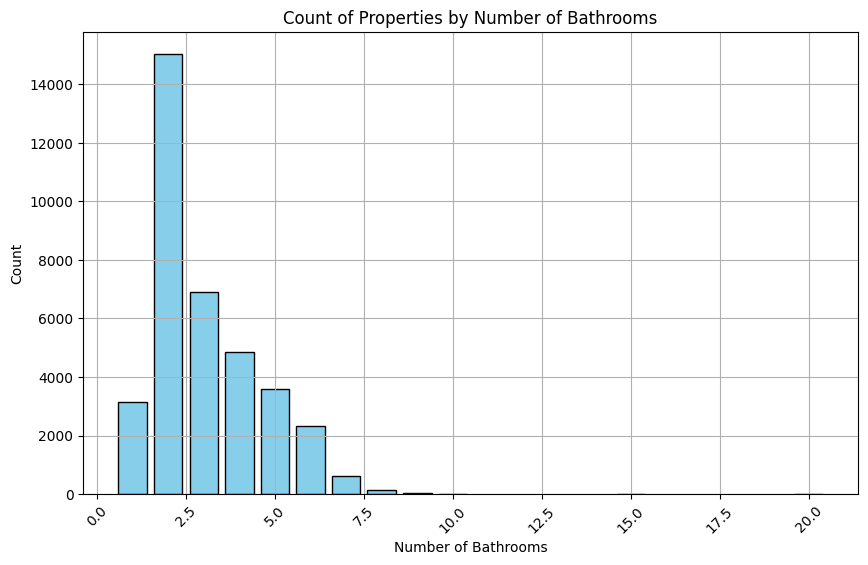

In [ ]:
# Calculate the frequency of each number of bathrooms
bathroom_counts = df1['Bathrooms'].value_counts()

# Create figure and axis objects
plt.figure(figsize=(10, 6))

# Plot bar chart for bathroom counts
plt.bar(bathroom_counts.index, bathroom_counts.values, color='skyblue', edgecolor='black')

# Set labels and title for the plot
plt.xlabel('Number of Bathrooms')
plt.ylabel('Count')
plt.title('Count of Properties by Number of Bathrooms')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show gridlines
plt.grid(True)

# Show the plot
plt.show()


Most properties have 2 to 4 bathrooms, while properties with more than 7 bathrooms are very rare, indicating that the majority fall within a typical residential range.

In [ ]:
bathrooms_df = df1[df1['Bathrooms'] == 	20]
bathrooms_df.head()

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing,Distance to Hospital (KM),Distance to Shopping_mall (KM),Distance to Train_station (KM),Distance to Primary_school (KM),Distance to Secondary_school (KM),Distance to University (KM),Size_type,g_size
6965,mont kiara,1579750,3,20,1,Serviced Residence,"1,775",Partly Furnished,0,0,3,0,1,2,Built-up,d.> 1000
12401,damansara,998000,4,20,2,2-sty Terrace/Link House,"1,650",Partly Furnished,1,1,1,1,1,1,Land area,d.> 1000
13649,wangsa maju,615000,4,20,2,2-sty Terrace/Link House,"1,080",Partly Furnished,1,0,"1,000",0,0,1,Land area,d.> 1000
19544,sungai besi,720000,3,20,2,Serviced Residence,"1,135",Partly Furnished,0,0,4,1,1,1,Built-up,d.> 1000


In [ ]:
# Drop the outlier
df1['bathrooms_Zscore'] = zscore(df1['Bathrooms'])

# Threshold for outlier detection (Z-score > 3)
outliers = df1[df1['bathrooms_Zscore'].abs() > 3]

# Remove outliers from the DataFrame
df1 = df1[df1['bathrooms_Zscore'].abs() <= 3]

# Drop the 'Price_Zscore' column
df1.drop(columns=['bathrooms_Zscore'], inplace=True)

<ipython-input-106-1c0f400bda10>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.drop(columns=['bathrooms_Zscore'], inplace=True)


### b. Data analysis

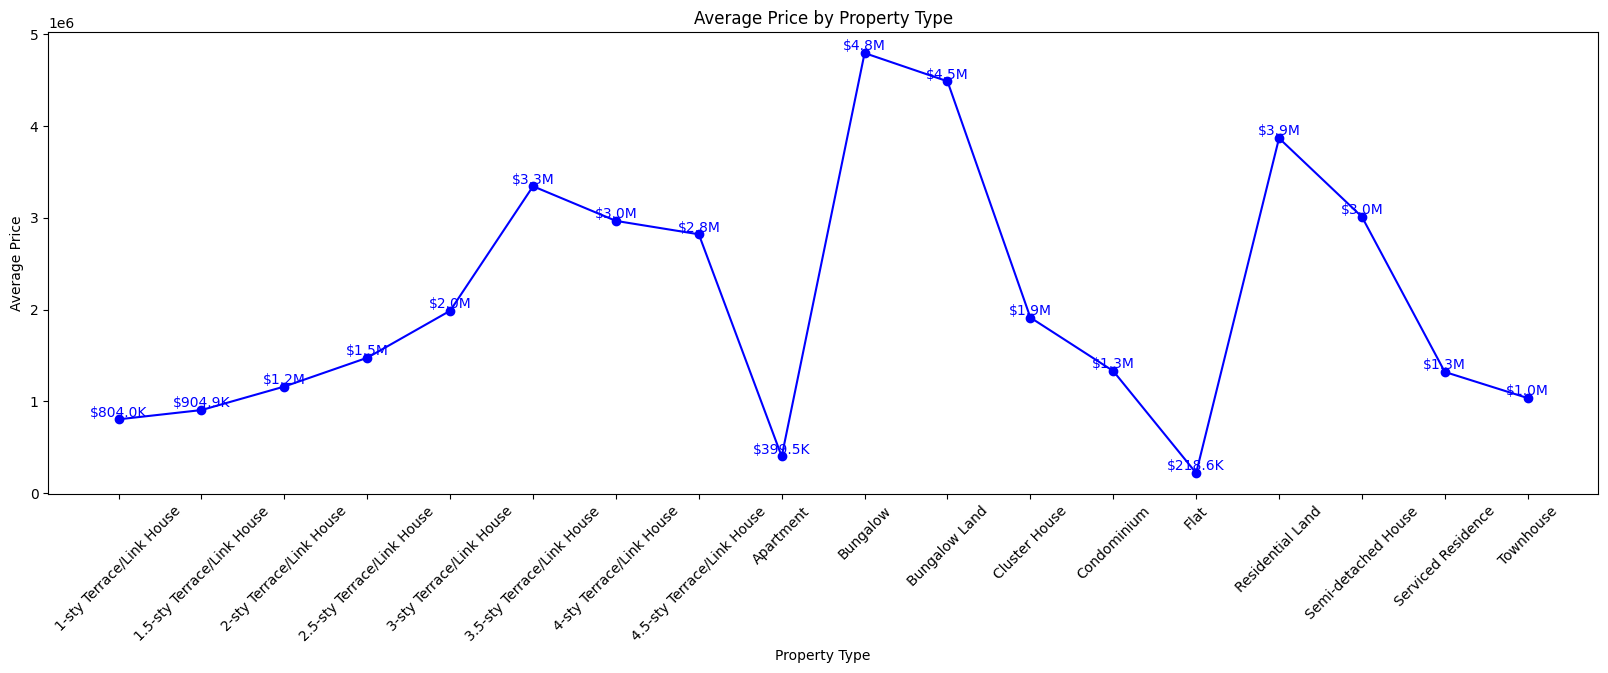

In [ ]:
# Function to format price
def format_price(price):
    if price >= 1e6:  # If price is greater than or equal to 1 million
        return f"${price / 1e6:.1f}M"  # Format in millions with one decimal place
    else:
        return f"${price / 1e3:.1f}K"  # Format in thousands with one decimal place

# Plot line plot for average price in a separate chart
average_price_by_column = df1.groupby(['Property Type'])['Price'].mean()

plt.figure(figsize=(20, 6))
ax2 = plt.gca()  # Primary axis for average price line plot
ax2.plot(average_price_by_column.index, average_price_by_column.values, marker='o', color='blue', linestyle='-')

# Add text annotations for median price
for x, y in zip(average_price_by_column.index, average_price_by_column.values):
  label = format_price(y)  # Format price using the defined function
  ax2.text(x, y, label, ha='center', va='bottom', color='blue')

# Set primary y-axis label
ax2.set_ylabel('Average Price')

# Set plot title and axis labels
plt.title(f'Average Price by Property Type')
ax2.set_xlabel('Property Type')
plt.ylabel('Average Price')

plt.xticks(rotation=45)  # Rotate location labels by 45 degrees for better readability

plt.show()

Property types such as Bungalow and Residential Land have the highest average prices, while Apartment and Flat properties are the most affordable

In [ ]:
df1.shape

(36424, 16)

#### Number of Properties with furnishing

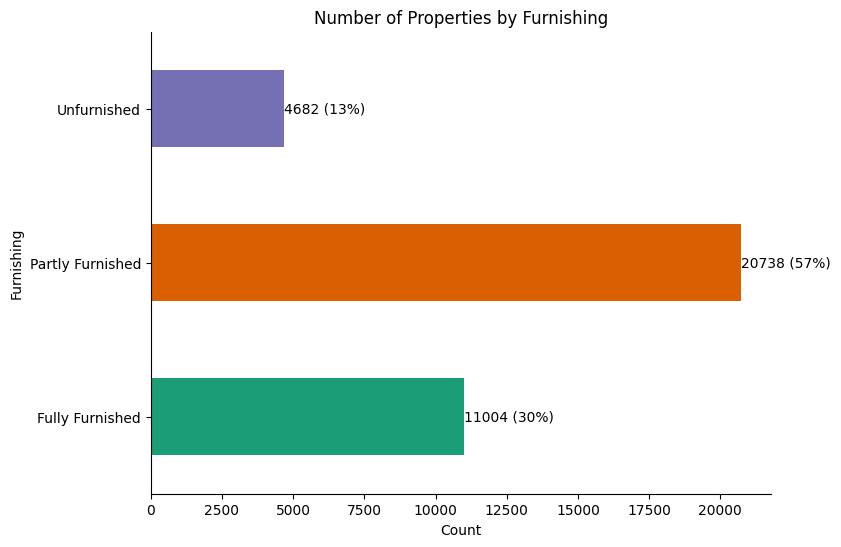

In [ ]:
# Group by 'Furnishing' and count occurrences
furnishing_counts = df1.groupby('Furnishing').size()

# Plot horizontal bar plot
plt.figure(figsize=(8, 6))
furnishing_counts.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))

# Add labels and percentages to the bars
total = furnishing_counts.sum()
for index, value in enumerate(furnishing_counts):
    label = f"{value} ({value / total:.0%})"
    plt.text(value, index, label, ha='left', va='center')

# Set plot title and axis labels
plt.title('Number of Properties by Furnishing')
plt.xlabel('Count')
plt.ylabel('Furnishing')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


The majority of properties are Partly Furnished (57%), followed by Fully Furnished (30%), while only a small portion are Unfurnished (13%). This shows a higher  preference for partially furnished properties.

#### Price vs Furnishing

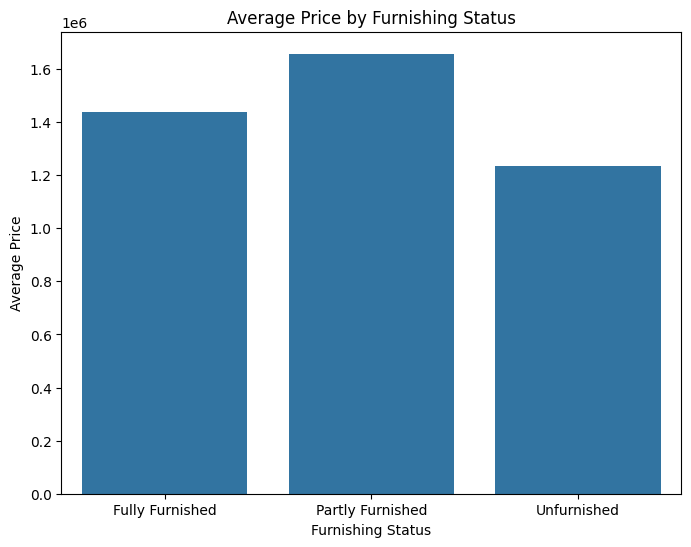

In [ ]:
#Group data by Furnishing status and calculate average price
price_by_furnishing = df1.groupby('Furnishing')['Price'].mean().reset_index()

#Plot the average price by furnishing status
plt.figure(figsize=(8, 6))
sns.barplot(data=price_by_furnishing, x='Furnishing', y='Price')
plt.xlabel("Furnishing Status")
plt.ylabel("Average Price")
plt.title("Average Price by Furnishing Status")
plt.show()


We found that furnishing status influences property value. Partly Furnished properties have the highest average price, followed by Fully Furnished, while Unfurnished properties have the lowest average price.

#### Property Types

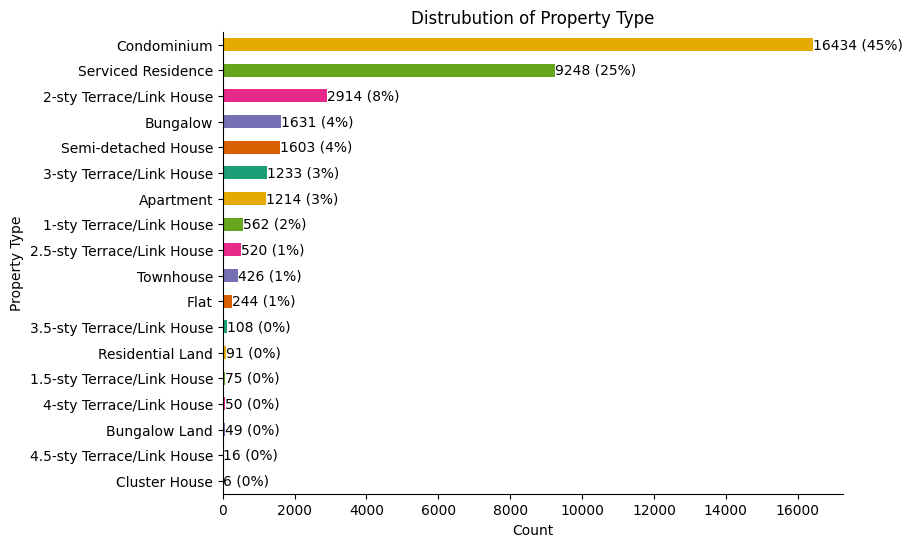

In [ ]:
# Group by 'Property Type' and count occurrences
property_type_counts = df1['Property Type'].value_counts().sort_values(ascending=True)

# Plot horizontal bar plot
plt.figure(figsize=(8, 6))
property_type_counts.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))

# Add labels and percentages to the bars
total = property_type_counts.sum()
for index, value in enumerate(property_type_counts):
    label = f"{value} ({value / total:.0%})"
    plt.text(value, index, label, ha='left', va='center')

# Set plot title and axis labels
plt.title('Distrubution of Property Type')
plt.xlabel('Count')
plt.ylabel('Property Type')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


Condominium properties dominate the dataset with 45%, followed by Serviced Residence (25%), while other property types like Cluster House and 4.5-sty Terrace/Link House have a minimal representation in our dataset.

In [ ]:
# Define property types that are considered "High Rise"
high_rise_lux_types = ['Serviced Residence', 'Condominium']

high_rise_usual_types = [ 'Apartment', 'Flat']


landed_luxury_types = ['Bungalow', 'Semi-detached House']

# Define property types that are considered "Landed Usual"
landed_usual_types = ['2-sty Terrace/Link House', '3-sty Terrace/Link House',
                      '2.5-sty Terrace/Link House', '3.5-sty Terrace/Link House',
                      '1.5-sty Terrace/Link House', '1-sty Terrace/Link House',
                      '4-sty Terrace/Link House', 'Townhouse', '4.5-sty Terrace/Link House',
                      'Residential Land', 'Bungalow Land', 'Cluster House']

# Create a new column 'Property Category' and assign values based on property type
df1['Property Category'] = np.where(df1['Property Type'].isin(high_rise_lux_types), 'High Rise Luxury',
                                    np.where(df1['Property Type'].isin(high_rise_usual_types), 'High Rise Usual',
                                             np.where(df1['Property Type'].isin(landed_luxury_types), 'Landed Luxury',
                                                      np.where(df1['Property Type'].isin(landed_usual_types), 'Landed Usual',
                                                               'Others'))))

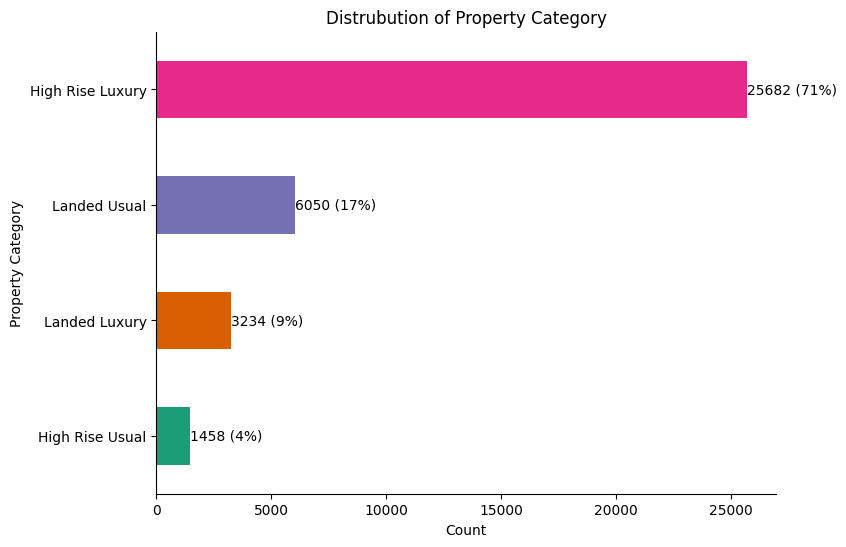

In [ ]:
# Group by 'Property Type' and count occurrences
property_type_counts = df1['Property Category'].value_counts().sort_values(ascending=True)

# Plot horizontal bar plot
plt.figure(figsize=(8, 6))
property_type_counts.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))

# Add labels and percentages to the bars
total = property_type_counts.sum()
for index, value in enumerate(property_type_counts):
    label = f"{value} ({value / total:.0%})"
    plt.text(value, index, label, ha='left', va='center')

# Set plot title and axis labels
plt.title('Distrubution of Property Category')
plt.xlabel('Count')
plt.ylabel('Property Category')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

For our dataset, High Rise Luxury properties dominate the dataset with 71%, while Landed Usual and Landed Luxury properties make up 17% and 9%, respectively.

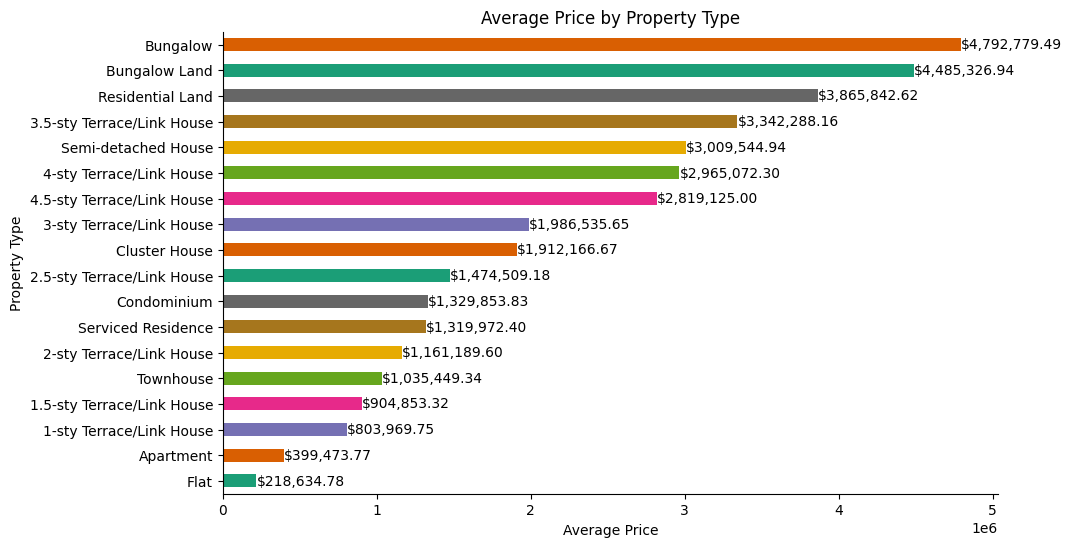

In [ ]:
# Group by 'Property Type' and compute average price
avg_price_by_property_type = df1.groupby('Property Type')['Price'].mean().sort_values(ascending=True)

# Plot horizontal bar plot
plt.figure(figsize=(10, 6))
avg_price_by_property_type.plot(kind='barh', color=sns.color_palette('Dark2'))

# Add labels to the bars
for index, value in enumerate(avg_price_by_property_type):
    plt.text(value, index, f"${value:,.2f}", ha='left', va='center')

# Set plot title and axis labels
plt.title('Average Price by Property Type')
plt.xlabel('Average Price')
plt.ylabel('Property Type')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


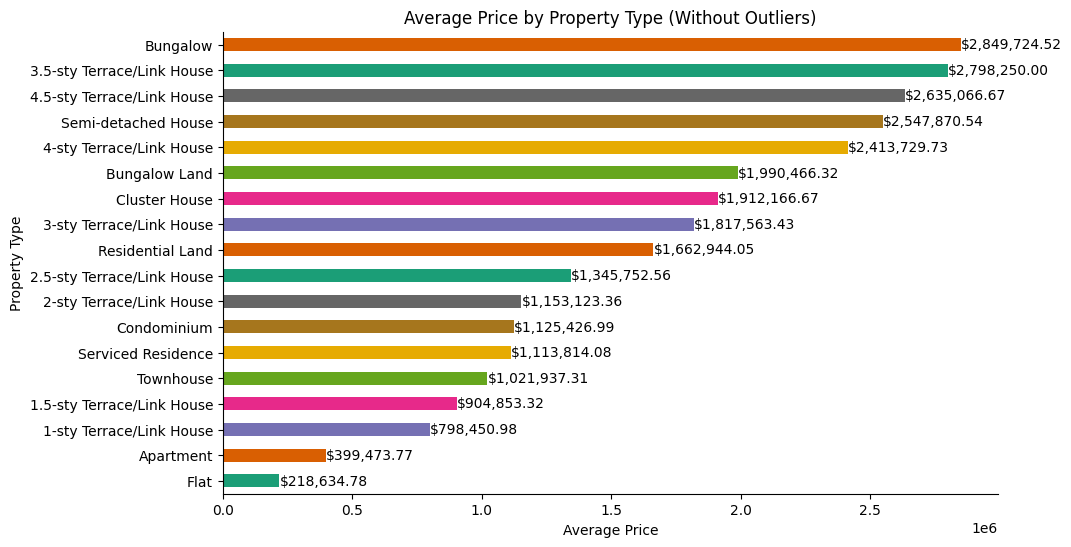

In [ ]:
# Identify outliers using IQR method
Q1 = df1['Price'].quantile(0.25)
Q3 = df1['Price'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df1_filtered = df1[(df1['Price'] >= lower_bound) & (df1['Price'] <= upper_bound)]

# Group by 'Property Type' and compute average price
avg_price_by_property_type = df1_filtered.groupby('Property Type')['Price'].mean().sort_values(ascending=True)

# Plot horizontal bar plot
plt.figure(figsize=(10, 6))
avg_price_by_property_type.plot(kind='barh', color=sns.color_palette('Dark2'))

# Add labels to the bars
for index, value in enumerate(avg_price_by_property_type):
    plt.text(value, index, f"${value:,.2f}", ha='left', va='center')

# Set plot title and axis labels
plt.title('Average Price by Property Type (Without Outliers)')
plt.xlabel('Average Price')
plt.ylabel('Property Type')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


After removing outliers, we can observe that the 3.5-sty Terrace/Link House and Bungalow remain the most expensive property types, while Flats and Apartments continue to have the lowest average prices.

#### Price vs property types (based on size)

In [ ]:
print("Summary Statistics for Size:")
print(df1['Size'].describe())

Summary Statistics for Size:
count    36,424
mean      2,179
std       9,744
min         406
25%       1,025
50%       1,426
75%       2,250
max     820,000
Name: Size, dtype: float64


<ipython-input-117-305bccd0a26c>:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_price_by_size = df1.groupby('Size_Category')['Price'].mean().reset_index()
<ipython-input-117-305bccd0a26c>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_price_by_size, x='Size_Category', y='Price', palette='coolwarm')


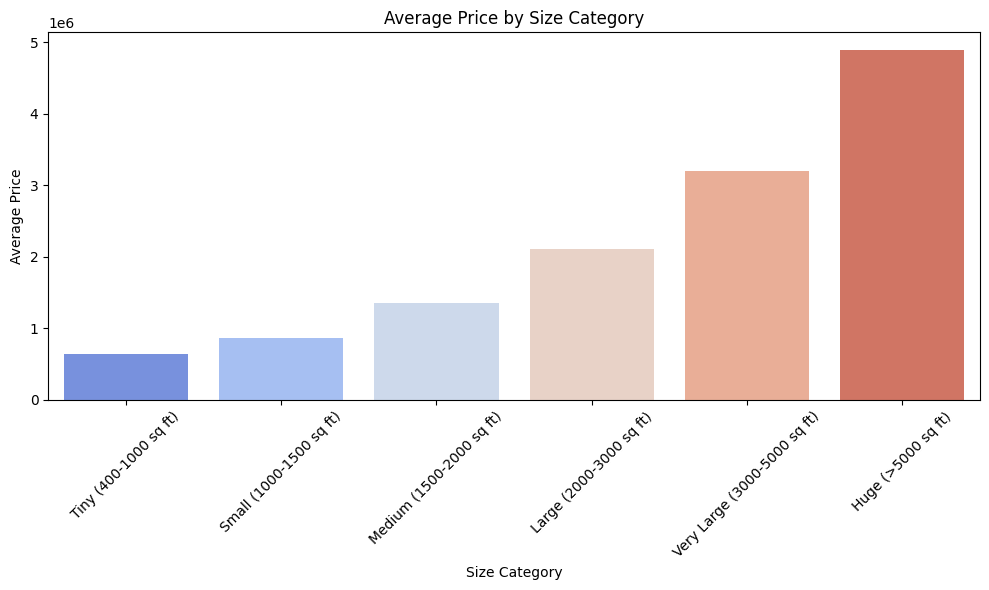

In [ ]:
# Define bins and labels for Size
bins = [400, 1000, 1500, 2000, 3000, 5000, float('inf')]
labels = ['Tiny (400-1000 sq ft)',
          'Small (1000-1500 sq ft)',
          'Medium (1500-2000 sq ft)',
          'Large (2000-3000 sq ft)',
          'Very Large (3000-5000 sq ft)',
          'Huge (>5000 sq ft)']

# Create a Size Category column
df1['Size_Category'] = pd.cut(df1['Size'], bins=bins, labels=labels, include_lowest=True)

# Group by Size Category and calculate average price
avg_price_by_size = df1.groupby('Size_Category')['Price'].mean().reset_index()

# Plot the average price by size category
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_price_by_size, x='Size_Category', y='Price', palette='coolwarm')

# Chart formatting
plt.xlabel("Size Category")
plt.ylabel("Average Price")
plt.title("Average Price by Size Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The average price increases consistently with property size, with Huge (>5000 sq ft) properties having the highest average prices, while Tiny (400-1000 sq ft) properties have the lowest.

#### Distance vs Price

<ipython-input-118-173ef38cebc5>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_price_by_distance = df1.groupby('Distance Range')['Price'].mean()


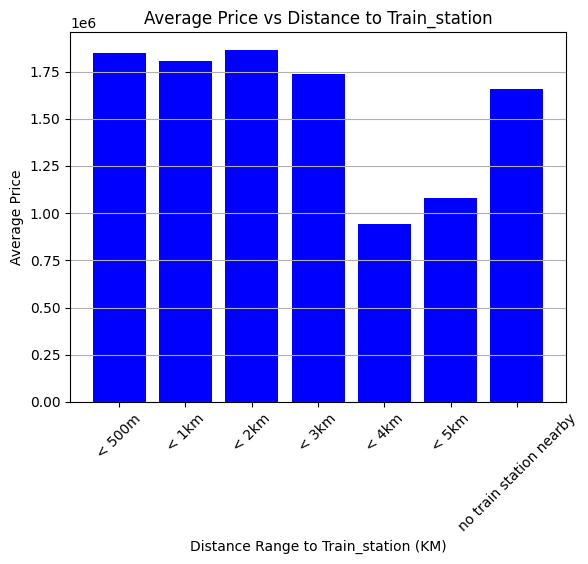

In [ ]:
distance_bins = [0, 0.5, 1, 2, 3, 4, 5, 1000]  # Define your own distance bins as needed
distance_labels = ['< 500m', '< 1km', '< 2km', '< 3km', '< 4km', '< 5km', 'no train station nearby']  # Labels for the distance bins

# Bin the data based on distance to the train station
df1['Distance Range'] = pd.cut(df1['Distance to Train_station (KM)'], bins=distance_bins, labels=distance_labels)

# Calculate the average price for each distance range
average_price_by_distance = df1.groupby('Distance Range')['Price'].mean()

# Create a bar plot
plt.bar(average_price_by_distance.index, average_price_by_distance.values, color='blue')
plt.title('Average Price vs Distance to Train_station')
plt.xlabel('Distance Range to Train_station (KM)')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.grid(axis='y')  # Show gridlines only on the y-axis
plt.show()

The chart indicates that properties closer to train stations (up to 2km) generally have higher average prices, with a noticeable drop beyond 3km. However, properties categorized as having "no train station nearby" have a higher average price compared to those 3–5km from a station. This suggests that other factors (like exclusivity or amenities) might drive higher prices in areas without nearby train stations, even though they lack that proximity.

#### Price vs Distance to facilities

In [ ]:
def format_price(price):
    if price >= 1e6:
        return f"${price / 1e6:.1f}M"
    else:
        return f"${price / 1e3:.1f}K"

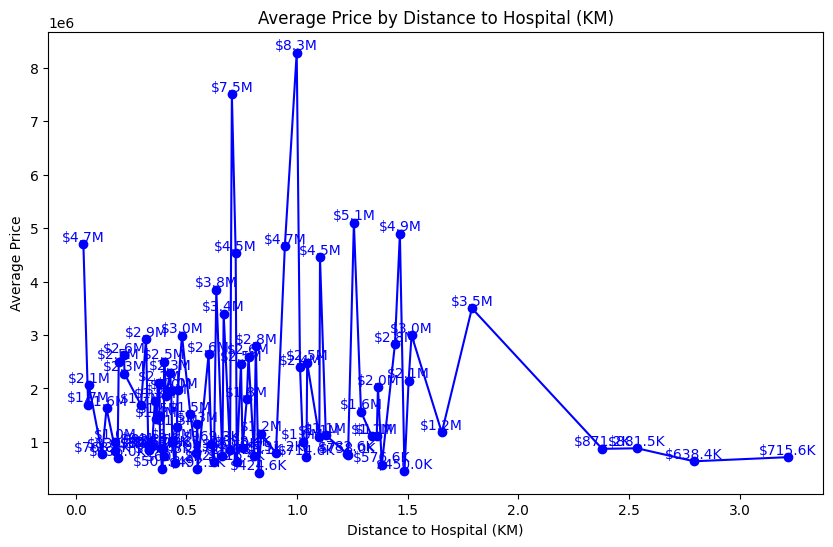

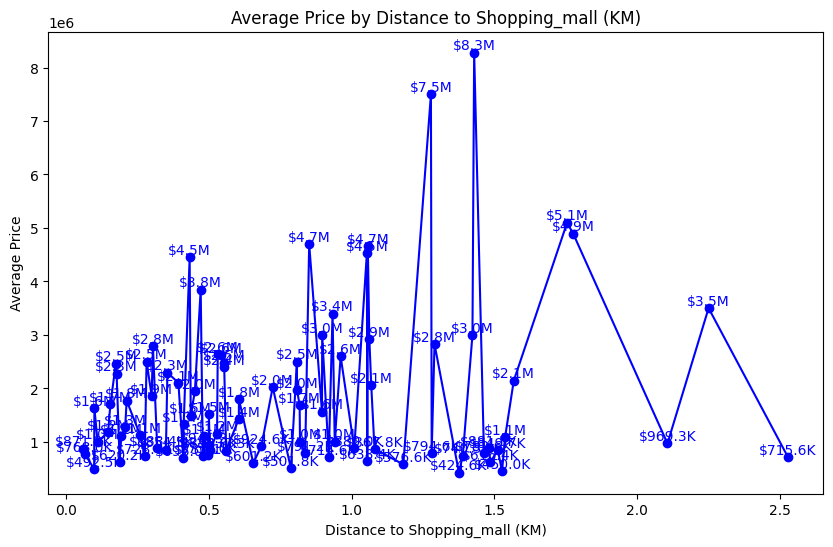

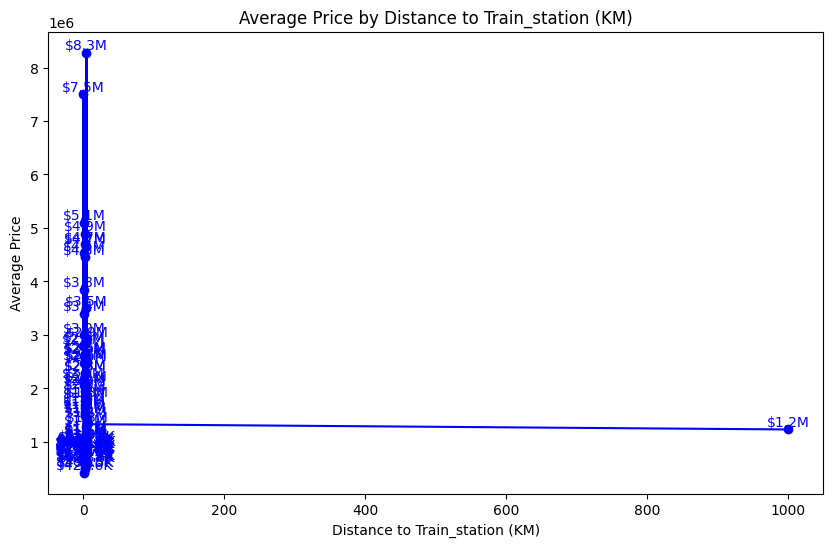

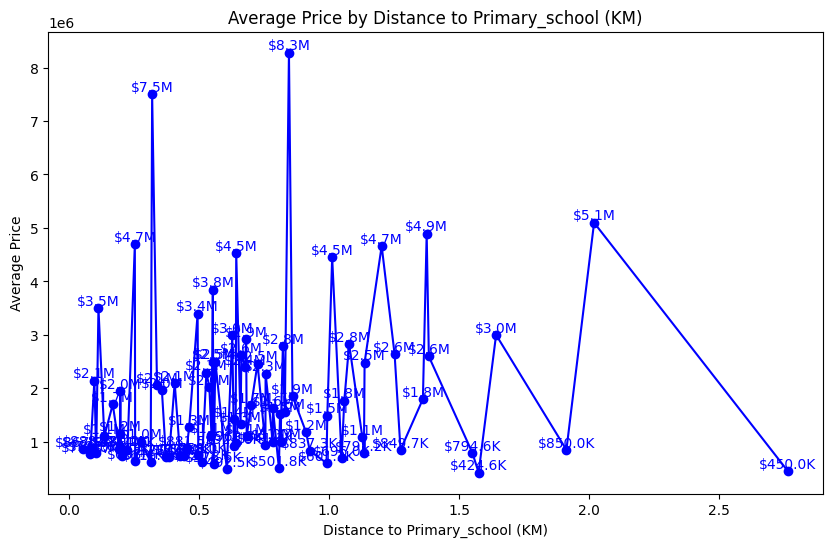

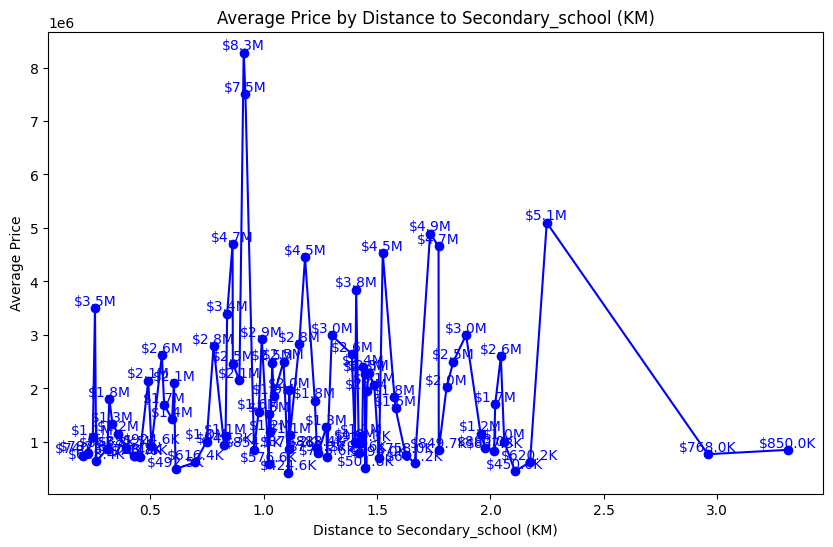

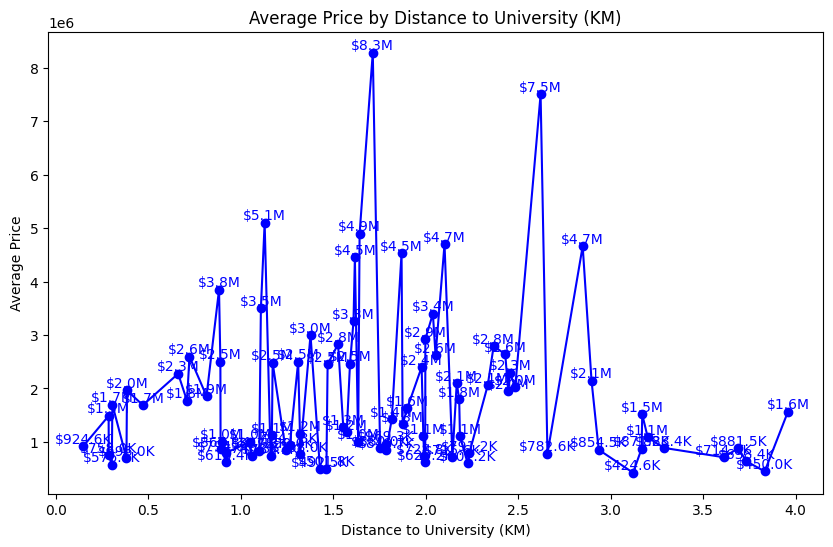

In [ ]:
# Define the distance-related columns
distance_columns = ['Distance to Hospital (KM)', 'Distance to Shopping_mall (KM)', 'Distance to Train_station (KM)',
                    'Distance to Primary_school (KM)', 'Distance to Secondary_school (KM)', 'Distance to University (KM)']

# Iterate over the distance columns
for column in distance_columns:
    # Group by the column and calculate the average price
    average_price_by_column = df1.groupby(column)['Price'].mean()

    # Plot line plot for median price
    plt.figure(figsize=(10, 6))
    plt.plot(average_price_by_column.index, average_price_by_column.values, marker='o', color='blue', linestyle='-')

    # Add text annotations for median price
    for x, y in zip(average_price_by_column.index, average_price_by_column.values):
        label = format_price(y)  # Format price using the defined function
        plt.text(x, y, label, ha='center', va='bottom', color='blue')

    # Set plot title and axis labels
    plt.title(f'Average Price by {column}')
    plt.xlabel(column)
    plt.ylabel('Average Price')

    plt.show()


#### Correlation Heatmap


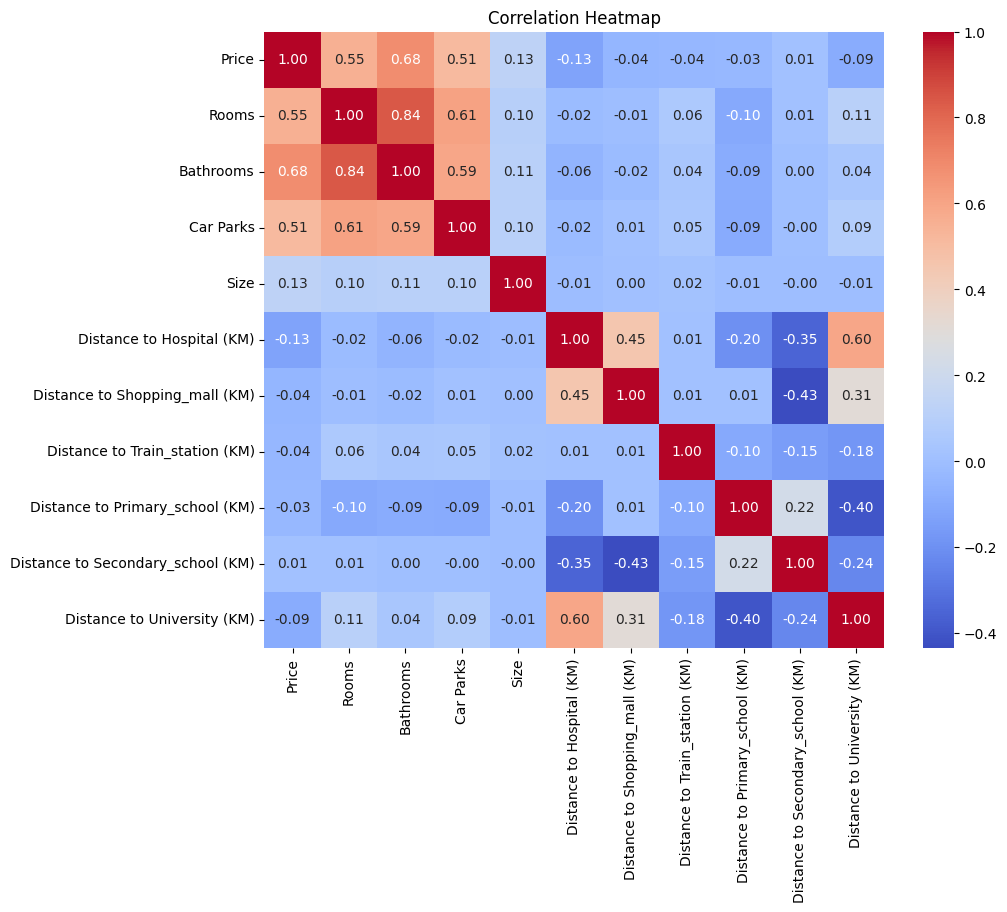

In [ ]:
# Filter for numeric columns only
numeric_df = df1.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(10, 8))
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


The Price of properties shows a strong positive correlation with Bathrooms (0.68) and Rooms (0.55), with strong influence on price.

# Data Pre-Processing (cont)

## d. Data Transformation
* The process of converting data into a suitable format or scale to improve model performance or meet algorithm requirements.

In [ ]:
df1.describe()

,Price,Rooms,Bathrooms,Car Parks,Size,Distance to Hospital (KM),Distance to Shopping_mall (KM),Distance to Train_station (KM),Distance to Primary_school (KM),Distance to Secondary_school (KM),Distance to University (KM)
count,"36,424","36,424","36,424","36,424","36,424","36,424","36,424","36,424","36,424","36,424","36,424"
mean,"1,535,789",4,3,2,"2,179",1,1,33,1,1,2
std,"1,438,390",1,1,1,"9,744",1,0,170,0,1,1
min,"105,000",1,1,1,406,0,0,0,0,0,0
25%,"600,000",3,2,1,"1,025",0,0,2,0,1,1
50%,"993,000",3,3,2,"1,426",0,0,3,1,1,2
75%,"1,900,000",4,4,2,"2,250",1,1,4,1,1,2
max,"8,653,750",7,7,30,"820,000",3,3,"1,000",3,3,4


### i) Normalisation

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, StratifiedKFold
from sklearn.linear_model import Lasso, LinearRegression

scaler = StandardScaler()

col_to_standardized=['Rooms', 'Bathrooms', 'Car Parks','Size','Distance to Hospital (KM)',
       'Distance to Shopping_mall (KM)', 'Distance to Train_station (KM)',
       'Distance to Primary_school (KM)', 'Distance to Secondary_school (KM)',
       'Distance to University (KM)']

#'Rooms', 'Bathrooms', 'Car Parks',

In [ ]:
df1[col_to_standardized] = scaler.fit_transform(df1[col_to_standardized])

### ii) Convert categorical to numerical

In [ ]:
cat_col = df1.select_dtypes(include=['object'])

In [ ]:
cat_col.columns

Index(['Location', 'Property Type', 'Furnishing', 'Size_type',
       'Property Category'],
      dtype='object')

In [ ]:
df1.info()
df2=df1.copy()

<class 'pandas.core.frame.DataFrame'>
Index: 36424 entries, 0 to 38589
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   Location                           36424 non-null  object  
 1   Price                              36424 non-null  int64   
 2   Rooms                              36424 non-null  float64 
 3   Bathrooms                          36424 non-null  float64 
 4   Car Parks                          36424 non-null  float64 
 5   Property Type                      36424 non-null  object  
 6   Size                               36424 non-null  float64 
 7   Furnishing                         36424 non-null  object  
 8   Distance to Hospital (KM)          36424 non-null  float64 
 9   Distance to Shopping_mall (KM)     36424 non-null  float64 
 10  Distance to Train_station (KM)     36424 non-null  float64 
 11  Distance to Primary_school (KM)    36424 non-n

In [ ]:
columns = ['Location', 'Property Type', 'Furnishing', 'Size_type','Property Category','g_size','Distance Range']

def val_col(col):
  for i in col:
    print(i, ":", df2[i].unique())
    print("\n")

val_col(columns)


Location : ['klcc' 'bukit damansara' 'mont kiara' 'bukit jalil' 'taman tun dr ismail'
 'sri petaling' 'desa parkcity' 'bangsar south' 'ampang' 'kepong'
 'kuchai lama' 'sungai besi' 'kl sentral' 'setapak' 'taman desa' 'sentul'
 'cheras' 'bangsar' 'segambut' 'wangsa maju' 'batu caves' 'bukit kiara'
 'country heights damansara' 'taman melawati' 'setiawangsa'
 'bukit bintang' 'sri hartamas' 'jalan sultan ismail' 'chan sow lin'
 'jalan kuching' 'bandar menjalara' 'bukit tunku' 'seputeh' 'sunway spk'
 'kl eco city' 'pantai' 'oug' 'jalan ipoh' 'mid valley city' 'desa pandan'
 'brickfields' 'pandan indah' 'desa petaling' 'federal hill'
 'pandan perdana' 'bandar damai perdana' 'puchong' 'keramat'
 'salak selatan' 'semarak' 'titiwangsa' 'damansara' 'alam damai'
 'bukit ledang' 'happy garden' 'pandan jaya' 'taman melati'
 'off gasing indah,' 'sungai penchala' 'taman duta' 'kuala lumpur'
 'taman wangsa permai' 'sri damansara' 'kota damansara' 'gombak'
 'taman connaught' 'rawang']


Property Type :

### a) Label encoder

In [ ]:
le = LabelEncoder()

df2['Size_type'] = le.fit_transform(df2['Size_type'])
df2.head(5)

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing,Distance to Hospital (KM),Distance to Shopping_mall (KM),Distance to Train_station (KM),Distance to Primary_school (KM),Distance to Secondary_school (KM),Distance to University (KM),Size_type,g_size,Property Category,Size_Category,Distance Range
0,klcc,1250000,-0,-0,0,Serviced Residence,-0,Fully Furnished,-1,-1,-0,0,0,-1,0,d.> 1000,High Rise Luxury,Small (1000-1500 sq ft),< 3km
1,bukit damansara,6800000,2,3,2,Bungalow,0,Partly Furnished,0,-0,-0,-0,0,-1,1,d.> 1000,Landed Luxury,Huge (>5000 sq ft),< 1km
2,mont kiara,1030000,-0,1,0,Condominium,-0,Partly Furnished,1,-1,-0,0,-1,0,0,d.> 1000,High Rise Luxury,Medium (1500-2000 sq ft),< 3km
3,bukit jalil,900000,1,-0,0,Condominium,-0,Partly Furnished,-1,-1,-0,1,-1,-1,0,d.> 1000,High Rise Luxury,Medium (1500-2000 sq ft),< 5km
4,taman tun dr ismail,5350000,2,1,2,Bungalow,1,Partly Furnished,-0,-0,-0,-1,-1,0,1,d.> 1000,Landed Luxury,Huge (>5000 sq ft),< 5km


### b) One hot encoding

In [ ]:
# Apply one-hot encoding with drop_first=False
df2= pd.get_dummies(df2, columns=['Location', 'Property Type', 'Furnishing',
                                  'Property Category',
                                  'g_size','Distance Range','Size_Category'],
                    dtype=int, drop_first=False)
df2.head()


,Price,Rooms,Bathrooms,Car Parks,Size,Distance to Hospital (KM),Distance to Shopping_mall (KM),Distance to Train_station (KM),Distance to Primary_school (KM),Distance to Secondary_school (KM),...,Distance Range_< 3km,Distance Range_< 4km,Distance Range_< 5km,Distance Range_no train station nearby,Size_Category_Tiny (400-1000 sq ft),Size_Category_Small (1000-1500 sq ft),Size_Category_Medium (1500-2000 sq ft),Size_Category_Large (2000-3000 sq ft),Size_Category_Very Large (3000-5000 sq ft),Size_Category_Huge (>5000 sq ft)
0,1250000,-0,-0,0,-0,-1,-1,-0,0,0,...,1,0,0,0,0,1,0,0,0,0
1,6800000,2,3,2,0,0,-0,-0,-0,0,...,0,0,0,0,0,0,0,0,0,1
2,1030000,-0,1,0,-0,1,-1,-0,0,-1,...,1,0,0,0,0,0,1,0,0,0
3,900000,1,-0,0,-0,-1,-1,-0,1,-1,...,0,0,1,0,0,0,1,0,0,0
4,5350000,2,1,2,1,-0,-0,-0,-1,-1,...,0,0,1,0,0,0,0,0,0,1


In [ ]:
df2.shape

(36424, 121)

In [ ]:
pd.set_option('display.max_rows', None)
print(df2.dtypes)


Price                                           int64
Rooms                                         float64
Bathrooms                                     float64
Car Parks                                     float64
Size                                          float64
Distance to Hospital (KM)                     float64
Distance to Shopping_mall (KM)                float64
Distance to Train_station (KM)                float64
Distance to Primary_school (KM)               float64
Distance to Secondary_school (KM)             float64
Distance to University (KM)                   float64
Size_type                                       int64
Location_alam damai                             int64
Location_ampang                                 int64
Location_bandar damai perdana                   int64
Location_bandar menjalara                       int64
Location_bangsar                                int64
Location_bangsar south                          int64
Location_batu caves         

## e. Data Reduction
* The process of reducing the volume or complexity of data while preserving its essential information for analysis.

### Feature Selection using LASSO

* A regression technique that performs feature selection by shrinking less important feature coefficients to zero, retaining only the most relevant predictors for house prices.

In [ ]:
lasso = Lasso()
param_grid={'alpha': [0.005, 0.01, 0.05, 0.1]}

In [ ]:
lasso_grid = GridSearchCV(lasso, param_grid, cv=3)
X = df2.drop(columns=['Price'])  # Features
y = df2['Price']  # Target variable
lasso_grid.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.232e+15, tolerance: 4.835e+12
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.347e+15, tolerance: 5.140e+12
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.399e+15, tolerance: 5.094e

GridSearchCV(cv=3, estimator=Lasso(),
             param_grid={'alpha': [0.005, 0.01, 0.05, 0.1]})

In [ ]:
best_alpha=lasso_grid.best_params_['alpha']
best_alpha

0.1

In [ ]:
lasso_model=Lasso(alpha=best_alpha)
X_selected=lasso_model.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.961e+15, tolerance: 7.536e+12
  model = cd_fast.enet_coordinate_descent(


In [ ]:
# Get the coefficients and corresponding feature names
coefficients = lasso_model.coef_
feature_names = X.columns

# Select features with non-zero coefficients
selected_features_lasso = feature_names[coefficients != 0]

print("Selected features using Lasso:")
print(selected_features_lasso)

Selected features using Lasso:
Index(['Rooms', 'Bathrooms', 'Car Parks', 'Size', 'Distance to Hospital (KM)',
       'Distance to Shopping_mall (KM)', 'Distance to Train_station (KM)',
       'Distance to Primary_school (KM)', 'Distance to Secondary_school (KM)',
       'Distance to University (KM)',
       ...
       'Distance Range_< 3km', 'Distance Range_< 4km', 'Distance Range_< 5km',
       'Distance Range_no train station nearby',
       'Size_Category_Tiny (400-1000 sq ft)',
       'Size_Category_Small (1000-1500 sq ft)',
       'Size_Category_Medium (1500-2000 sq ft)',
       'Size_Category_Large (2000-3000 sq ft)',
       'Size_Category_Very Large (3000-5000 sq ft)',
       'Size_Category_Huge (>5000 sq ft)'],
      dtype='object', length=119)


In [ ]:
# Select features with zero coefficients
not_selected_features_lasso = feature_names[coefficients == 0]

print("Not selected features using Lasso:")
print(not_selected_features_lasso)

Not selected features using Lasso:
Index(['g_size_a.<400'], dtype='object')


In [ ]:
# Print the selected features as a full list
print(selected_features_lasso.tolist())


['Rooms', 'Bathrooms', 'Car Parks', 'Size', 'Distance to Hospital (KM)', 'Distance to Shopping_mall (KM)', 'Distance to Train_station (KM)', 'Distance to Primary_school (KM)', 'Distance to Secondary_school (KM)', 'Distance to University (KM)', 'Size_type', 'Location_alam damai', 'Location_ampang', 'Location_bandar damai perdana', 'Location_bandar menjalara', 'Location_bangsar', 'Location_bangsar south', 'Location_batu caves', 'Location_brickfields', 'Location_bukit bintang', 'Location_bukit damansara', 'Location_bukit jalil', 'Location_bukit kiara', 'Location_bukit ledang', 'Location_bukit tunku', 'Location_chan sow lin', 'Location_cheras', 'Location_country heights damansara', 'Location_damansara', 'Location_desa pandan', 'Location_desa parkcity', 'Location_desa petaling', 'Location_federal hill', 'Location_gombak', 'Location_happy garden', 'Location_jalan ipoh', 'Location_jalan kuching', 'Location_jalan sultan ismail', 'Location_kepong', 'Location_keramat', 'Location_kl eco city', 'L

In [ ]:
selected_data = df2[selected_features_lasso.tolist() + ['Price']]
print(selected_data.head())

   Rooms  Bathrooms  Car Parks  Size  Distance to Hospital (KM)  \
0     -0         -0          0    -0                         -1   
1      2          3          2     0                          0   
2     -0          1          0    -0                          1   
3      1         -0          0    -0                         -1   
4      2          1          2     1                         -0   

   Distance to Shopping_mall (KM)  Distance to Train_station (KM)  \
0                              -1                              -0   
1                              -0                              -0   
2                              -1                              -0   
3                              -1                              -0   
4                              -0                              -0   

   Distance to Primary_school (KM)  Distance to Secondary_school (KM)  \
0                                0                                  0   
1                               -0  

In [ ]:
print(selected_data.columns.tolist())

['Rooms', 'Bathrooms', 'Car Parks', 'Size', 'Distance to Hospital (KM)', 'Distance to Shopping_mall (KM)', 'Distance to Train_station (KM)', 'Distance to Primary_school (KM)', 'Distance to Secondary_school (KM)', 'Distance to University (KM)', 'Size_type', 'Location_alam damai', 'Location_ampang', 'Location_bandar damai perdana', 'Location_bandar menjalara', 'Location_bangsar', 'Location_bangsar south', 'Location_batu caves', 'Location_brickfields', 'Location_bukit bintang', 'Location_bukit damansara', 'Location_bukit jalil', 'Location_bukit kiara', 'Location_bukit ledang', 'Location_bukit tunku', 'Location_chan sow lin', 'Location_cheras', 'Location_country heights damansara', 'Location_damansara', 'Location_desa pandan', 'Location_desa parkcity', 'Location_desa petaling', 'Location_federal hill', 'Location_gombak', 'Location_happy garden', 'Location_jalan ipoh', 'Location_jalan kuching', 'Location_jalan sultan ismail', 'Location_kepong', 'Location_keramat', 'Location_kl eco city', 'L

## f. Data Spliting
* The process of dividing a dataset into different subsets for the purpose of training and evaluating machine learning models.
* Data is split into 80% training and 20% testing.

In [ ]:
selected_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36424 entries, 0 to 38589
Columns: 120 entries, Rooms to Price
dtypes: float64(10), int64(110)
memory usage: 33.6 MB


In [ ]:
selected_data.to_csv('/content/drive/MyDrive/WQD7003/x_selected.csv', index=False)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

dataset_file_path = '/content/drive/MyDrive/WQD7003/x_selected.csv'

# Load the dataset into a DataFrame
selected_data = pd.read_csv(dataset_file_path)

# Separate features and target
X = selected_data.drop(columns=['Price'])
y = selected_data['Price']

# Split into training (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Output sizes for verification
print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")


Training set: 29139 samples
Test set: 7285 samples


In [ ]:
import pandas as pd
import os

# Define the directory path
directory_path = '/content/drive/MyDrive/WQD7003/v2'

# Create the directory if it doesn't exist
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# Combine features and target
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# Save to CSV
train_data.to_csv(f'{directory_path}/train_data.csv', index=False)
test_data.to_csv(f'{directory_path}/test_data.csv', index=False)


#3. Machine Learning Modeling

### a) Multiple Linear Regression

Training R²: 0.7860479278599182
Test R²: 0.7879429481720387
Training RMSE: 663761.67073329
Test RMSE: 668513.3149619794
Training RMSLE: 1.181101750636869
Test RMSLE: 1.2482506735919088


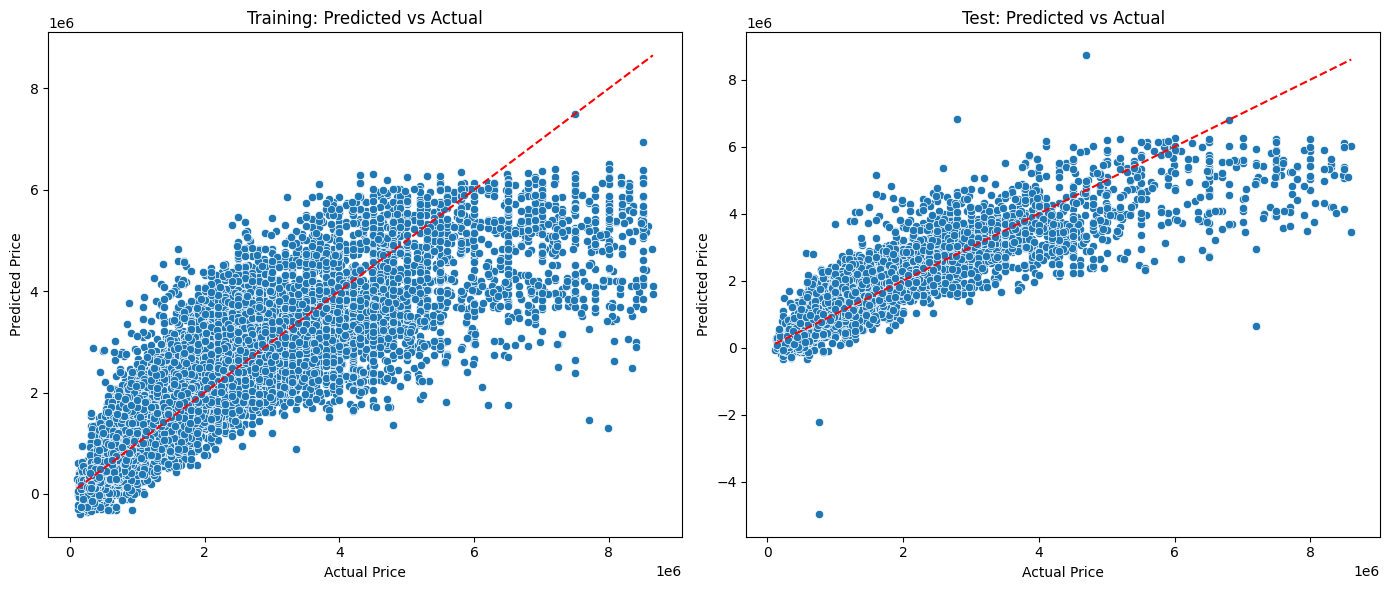

In [ ]:
# Define RMSLE calculation function
def rmsle(y_true, y_pred):
    y_pred = np.maximum(0, y_pred)  # Ensure non-negative predictions
    y_true = np.maximum(0, y_true)  # Ensure non-negative actual values
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

# Specify the target variable
target = 'Price'

# Prepare training data
X_train = train_data.drop(columns=[target])  # Features for training
y_train = train_data[target]  # Target for training

# Prepare test data
X_test = test_data.drop(columns=[target])  # Features for testing
y_test = test_data[target]  # Target for testing

# Train a model
model_mlr = LinearRegression()
model_mlr.fit(X_train, y_train)

# Predictions on the training set
y_train_pred = model_mlr.predict(X_train)

# Evaluate the model on the training set
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = mse_train ** 0.5
rmsle_train = rmsle(y_train, y_train_pred)

# Assign the variables
mlr_rmse_train = rmse_train
mlr_rmsle_train = rmsle_train

# Predictions on the test set
y_test_pred = model_mlr.predict(X_test)

# Evaluate the model on the test set
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = mse_test ** 0.5
rmsle_test = rmsle(y_test, y_test_pred)

# Assign the variables
mlr_rmse_test = rmse_test
mlr_rmsle_test = rmsle_test

# Calculate R² score for training and test sets
mlr_train_r2 = model_mlr.score(X_train, y_train)  # R² for training set
mlr_test_r2 = model_mlr.score(X_test, y_test)  # R² for test set

# Print the results for confirmation
print(f"Training R²: {mlr_train_r2}")
print(f"Test R²: {mlr_test_r2}")
print(f"Training RMSE: {mlr_rmse_train}")
print(f"Test RMSE: {mlr_rmse_test}")
print(f"Training RMSLE: {mlr_rmsle_train}")
print(f"Test RMSLE: {mlr_rmsle_test}")

# Plot predictions vs. actual values for both training and test sets
plt.figure(figsize=(14, 6))

# Subplot for Training Data
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train, y=y_train_pred)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')  # Line of perfect prediction
plt.title('Training: Predicted vs Actual')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

# Subplot for Test Data
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_test_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Line of perfect prediction
plt.title('Test: Predicted vs Actual')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

# Show the plots
plt.tight_layout()
plt.show()


* The Multiple Linear Regression model shows moderate performance in predicting house prices, with a training **R² of 78.6% and a test R² of 78.8%.** This suggests that the model explains a significant portion of the variance in house prices for both the training and test datasets, with only a slight difference in performance between them.

* The training **RMSE is RM663,762 and the test RMSE is RM668,513**, which indicates a relatively consistent level of error across both datasets. These high RMSE values suggest that the model's predictions are off by a significant amount in absolute terms, though the error is fairly consistent between training and test sets.

* The RMSLE values are also relatively high: **1.18 for training and 1.25 for testing.** These values point to notable proportional differences between predicted and actual prices, indicating that the model struggles more with smaller price differences or predictions for lower-priced houses.

* The scatter plots reveal that while there is some alignment along the red diagonal line (indicating ideal predictions), there is noticeable dispersion, particularly for higher-priced houses and in the test set. This suggests that while the model captures the overall trend in house prices, it still has room for improvement in terms of precision and generalization.

### b) Random Forest

Training R²: 0.9830567114890942
Test R²: 0.9203457684951339
Training RMSE: 186789.63556292065
Test RMSE: 409720.9094172815
Training RMSLE: 0.0927233440868517
Test RMSLE: 0.1807508329190798


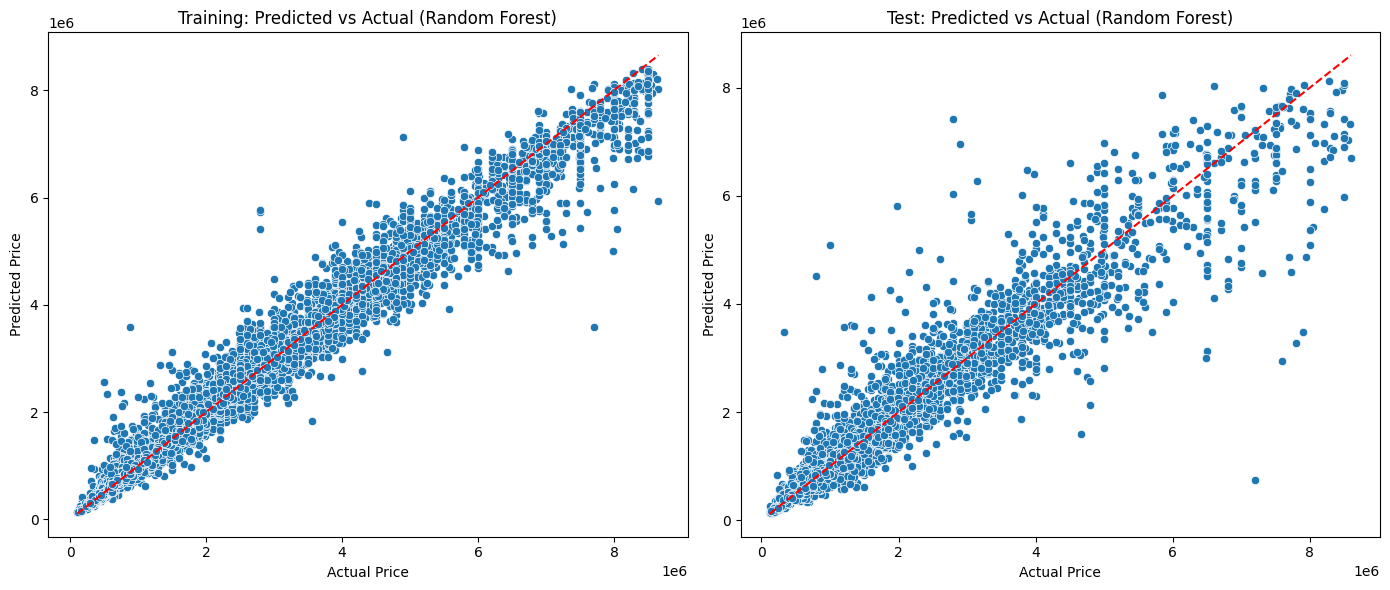

In [ ]:
# Define RMSLE calculation function
def rmsle(y_true, y_pred):
    y_pred = np.maximum(0, y_pred)  # Ensure non-negative predictions
    y_true = np.maximum(0, y_true)  # Ensure non-negative actual values
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

# Specify the target variable
target = 'Price'

# Prepare training data
X_train = train_data.drop(columns=[target])  # Features for training
y_train = train_data[target]  # Target for training

# Prepare test data
X_test = test_data.drop(columns=[target])  # Features for testing
y_test = test_data[target]  # Target for testing

# Train a Random Forest Regressor model
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)

# Predictions on the training set
y_train_pred_rf = model_rf.predict(X_train)

# Evaluate the model on the training set
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
rmse_train_rf = mse_train_rf ** 0.5
rmsle_train_rf = rmsle(y_train, y_train_pred_rf)

# Assign the variables
rf_rmse_train = rmse_train_rf
rf_rmsle_train = rmsle_train_rf

# Predictions on the test set
y_test_pred_rf = model_rf.predict(X_test)

# Evaluate the model on the test set
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
rmse_test_rf = mse_test_rf ** 0.5
rmsle_test_rf = rmsle(y_test, y_test_pred_rf)

# Assign the variables
rf_rmse_test = rmse_test_rf
rf_rmsle_test = rmsle_test_rf

# Calculate R² score for training and test sets
rf_train_r2 = model_rf.score(X_train, y_train)  # R² for training set
rf_test_r2 = model_rf.score(X_test, y_test)  # R² for test set

# Print the results for confirmation
print(f"Training R²: {rf_train_r2}")
print(f"Test R²: {rf_test_r2}")
print(f"Training RMSE: {rf_rmse_train}")
print(f"Test RMSE: {rf_rmse_test}")
print(f"Training RMSLE: {rf_rmsle_train}")
print(f"Test RMSLE: {rf_rmsle_test}")

# Plot predictions vs. actual values for both training and test sets
plt.figure(figsize=(14, 6))

# Subplot for Training Data
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train, y=y_train_pred_rf)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')  # Line of perfect prediction
plt.title('Training: Predicted vs Actual (Random Forest)')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

# Subplot for Test Data
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_test_pred_rf)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Line of perfect prediction
plt.title('Test: Predicted vs Actual (Random Forest)')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

# Show the plots
plt.tight_layout()
plt.show()


* The Random Forest model performs exceptionally well in predicting house prices,
achieving an **impressive R² score of 98.31% on the training data and 92.03% on the test data**. This indicates that the model explains almost all of the variance in house prices for both datasets, demonstrating strong predictive power.

* The training **RMSE is very low at RM186,789**, suggesting the model fits the training data very well. The **test RMSE is slightly higher at RM409,720,** indicating potential sign of overfitting.

* T**he RMSLE values are also quite low: 0.0928 for training and 0.181 for test**, which indicates the model's ability to predict house prices with high accuracy in relative terms, and it performs well across varying price ranges, without significant proportional errors.

* The scatterplots for training and test datasets illustrate that the predicted prices align closely with actual values, with most points distributed along the red diagonal line (representing perfect predictions). While there is some spread, especially in the test set for higher prices, the overall alignment suggests the model is making accurate predictions.

### b) Random Forest - Tuning

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Hyperparameters: {'n_estimators': 140, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 30}
Best Cross-Validation Score: 0.900662008364665
Test R²: 0.9207003935682658
Test RMSE: 408807.84187751263
Test RMSLE: 0.18261942317714464


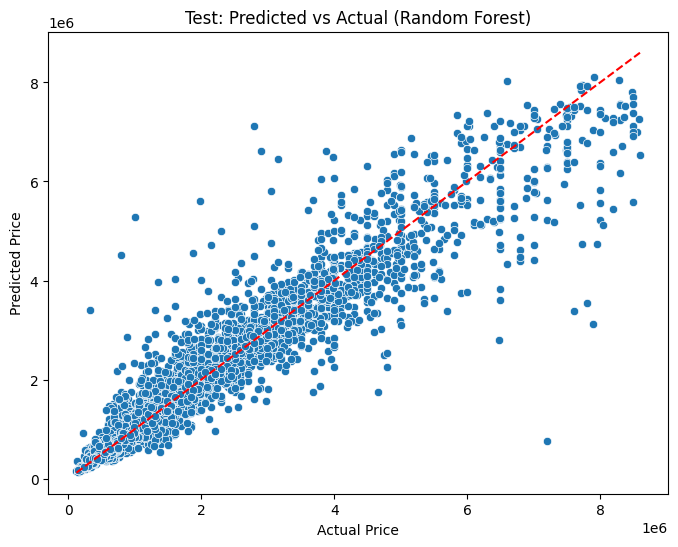

In [ ]:

# Define RMSLE calculation function
def rmsle(y_true, y_pred):
    y_pred = np.maximum(0, y_pred)
    y_true = np.maximum(0, y_true)
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

# Specify the target variable
target = 'Price'

# Prepare training data
X_train = train_data.drop(columns=[target])
y_train = train_data[target]

# Prepare test data
X_test = test_data.drop(columns=[target])
y_test = test_data[target]

# Define the parameter grid
param_dist = {
    'n_estimators': [120, 130, 140, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}


rf_model = RandomForestRegressor(random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    rf_model,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score}")

# Use the best estimator to make predictions
best_rf_model = random_search.best_estimator_

# Predictions on the test set
y_test_pred_rf = best_rf_model.predict(X_test)

# Evaluate the model on the test set
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
rmse_test_rf = mse_test_rf ** 0.5
rmsle_test_rf = rmsle(y_test, y_test_pred_rf)

# Assign the variables
rf_rmse_test = rmse_test_rf
rf_rmsle_test = rmsle_test_rf

# Calculate R² score for test set
rf_test_r2 = best_rf_model.score(X_test, y_test)

# Print the results for confirmation
print(f"Test R²: {rf_test_r2}")
print(f"Test RMSE: {rf_rmse_test}")
print(f"Test RMSLE: {rf_rmsle_test}")

# Plot predictions vs. actual values for the test set
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_test_pred_rf)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Line of perfect prediction
plt.title('Test: Predicted vs Actual (Random Forest)')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()


Training R²: 0.9668346962543228
Test R²: 0.9207003935682658
Training RMSE: 261333.99726071267
Test RMSE: 408807.84187751263
Training RMSLE: 0.12356389179832734
Test RMSLE: 0.18261942317714464


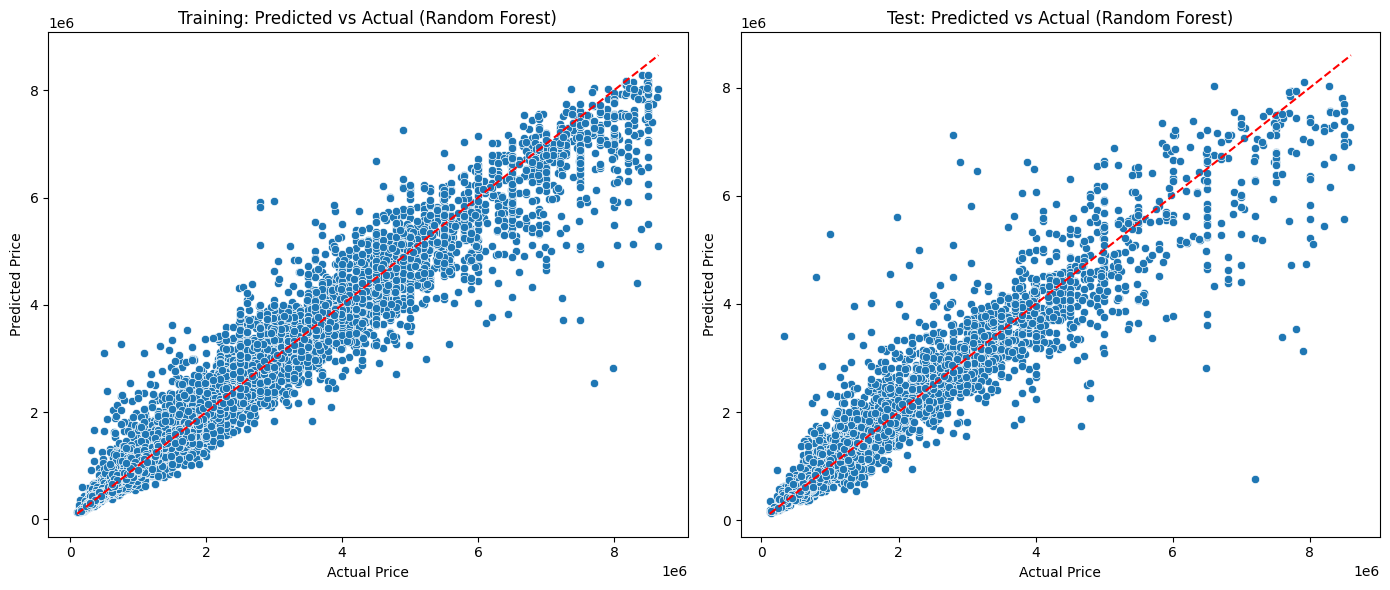

In [ ]:
# use the Best Hyperparameters: {'n_estimators': 140, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 30}

model_rf = rf_model = RandomForestRegressor(
    n_estimators=140,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features=None,
    max_depth=30,
    random_state=42
)

model_rf.fit(X_train, y_train)

# Predictions on the training set
y_train_pred_rf = model_rf.predict(X_train)

# Evaluate the model on the training set
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
rmse_train_rf = mse_train_rf ** 0.5
rmsle_train_rf = rmsle(y_train, y_train_pred_rf)

# Assign the variables
rf_rmse_train = rmse_train_rf
rf_rmsle_train = rmsle_train_rf

# Predictions on the test set
y_test_pred_rf = model_rf.predict(X_test)

# Evaluate the model on the test set
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
rmse_test_rf = mse_test_rf ** 0.5
rmsle_test_rf = rmsle(y_test, y_test_pred_rf)

# Assign the variables
rf_rmse_test = rmse_test_rf
rf_rmsle_test = rmsle_test_rf

# Calculate R² score for training and test sets
rf_train_r2 = model_rf.score(X_train, y_train)  # R² for training set
rf_test_r2 = model_rf.score(X_test, y_test)  # R² for test set

# Print the results for confirmation
print(f"Training R²: {rf_train_r2}")
print(f"Test R²: {rf_test_r2}")
print(f"Training RMSE: {rf_rmse_train}")
print(f"Test RMSE: {rf_rmse_test}")
print(f"Training RMSLE: {rf_rmsle_train}")
print(f"Test RMSLE: {rf_rmsle_test}")

# Plot predictions vs. actual values for both training and test sets
plt.figure(figsize=(14, 6))

# Subplot for Training Data
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train, y=y_train_pred_rf)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')  # Line of perfect prediction
plt.title('Training: Predicted vs Actual (Random Forest)')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

# Subplot for Test Data
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_test_pred_rf)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Line of perfect prediction
plt.title('Test: Predicted vs Actual (Random Forest)')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

# Show the plots
plt.tight_layout()
plt.show()


Importance Features

In [ ]:
# Extract feature importances from the trained Random Forest model
importances = model_rf.feature_importances_

# Create a DataFrame for all feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the entire feature importance table
print(feature_importance_df)

# Optionally save the table as a CSV file
feature_importance_df.to_csv('feature_importance_all.csv', index=False)


                           Feature  Importance
3                             Size    0.742684
6   Distance to Train_station (KM)    0.035855
9      Distance to University (KM)    0.027069
1                        Bathrooms    0.024666
42                   Location_klcc    0.023838
..                             ...         ...
72           Location_taman melati    0.000000
71             Location_taman duta    0.000000
69        Location_taman connaught    0.000000
63          Location_sri damansara    0.000000
89     Property Type_Cluster House    0.000000

[119 rows x 2 columns]


In [ ]:
# Display the top 20 most important features
top_20_features = feature_importance_df.head(20)
print(top_20_features)

# Optionally save the top 20 features as a CSV file
top_20_features.to_csv('top_20_feature_importance.csv', index=False)

                                Feature  Importance
3                                  Size    0.742684
6        Distance to Train_station (KM)    0.035855
9           Distance to University (KM)    0.027069
1                             Bathrooms    0.024666
42                        Location_klcc    0.023838
94     Property Type_Serviced Residence    0.015963
0                                 Rooms    0.010793
102      Property Category_Landed Usual    0.009995
4             Distance to Hospital (KM)    0.009887
2                             Car Parks    0.008712
5        Distance to Shopping_mall (KM)    0.008695
15                     Location_bangsar    0.008630
8     Distance to Secondary_school (KM)    0.007571
7       Distance to Primary_school (KM)    0.006837
90            Property Type_Condominium    0.006265
109                Distance Range_< 3km    0.004212
30               Location_desa parkcity    0.004046
99   Property Category_High Rise Luxury    0.003950
10          

### c) XGBoost

Training R²: 0.9353840947151184
Test R²: 0.9031054377555847
Training RMSE: 364773.8039717216
Test RMSE: 451890.7438928131
Training RMSLE: 0.1986313187651194
Test RMSLE: 0.22160613117349365


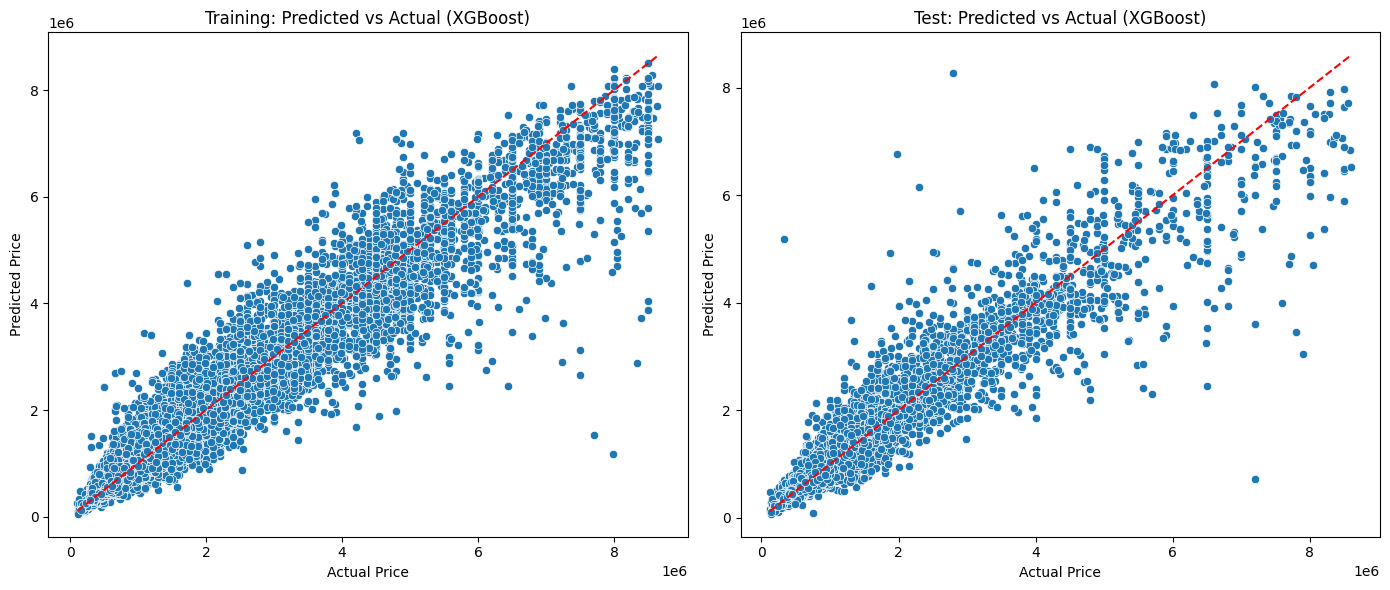

In [ ]:
from xgboost import XGBRegressor

# Define RMSLE calculation function
def rmsle(y_true, y_pred):
    y_pred = np.maximum(0, y_pred)  # Ensure non-negative predictions
    y_true = np.maximum(0, y_true)  # Ensure non-negative actual values
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))


# Clean column names: Replace any invalid characters like brackets or spaces
train_data.columns = train_data.columns.str.replace('[', '_').str.replace(']', '_').str.replace(' ', '_').str.replace('<', '_').str.replace('>', '_')
test_data.columns = test_data.columns.str.replace('[', '_').str.replace(']', '_').str.replace(' ', '_').str.replace('<', '_').str.replace('>', '_')

# Specify the target variable
target = 'Price'

# Prepare training data
X_train = train_data.drop(columns=[target])  # Features for training
y_train = train_data[target]  # Target for training

# Prepare test data
X_test = test_data.drop(columns=[target])  # Features for testing
y_test = test_data[target]  # Target for testing

# Train an XGBoost Regressor model
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)

# Predictions on the training set
y_train_pred_xgb = model_xgb.predict(X_train)

# Evaluate the model on the training set
mse_train_xgb = mean_squared_error(y_train, y_train_pred_xgb)
rmse_train_xgb = mse_train_xgb ** 0.5
rmsle_train_xgb = rmsle(y_train, y_train_pred_xgb)

# Assign the variables for training set
xgb_rmse_train = rmse_train_xgb
xgb_rmsle_train = rmsle_train_xgb

# Predictions on the test set
y_test_pred_xgb = model_xgb.predict(X_test)

# Evaluate the model on the test set
mse_test_xgb = mean_squared_error(y_test, y_test_pred_xgb)
rmse_test_xgb = mse_test_xgb ** 0.5
rmsle_test_xgb = rmsle(y_test, y_test_pred_xgb)

# Assign the variables for test set
xgb_rmse_test = rmse_test_xgb
xgb_rmsle_test = rmsle_test_xgb

# Calculate R² score for training and test sets
xgb_train_r2 = model_xgb.score(X_train, y_train)  # R² for training set
xgb_test_r2 = model_xgb.score(X_test, y_test)  # R² for test set

# Print the results for confirmation
print(f"Training R²: {xgb_train_r2}")
print(f"Test R²: {xgb_test_r2}")
print(f"Training RMSE: {xgb_rmse_train}")
print(f"Test RMSE: {xgb_rmse_test}")
print(f"Training RMSLE: {xgb_rmsle_train}")
print(f"Test RMSLE: {xgb_rmsle_test}")

# Plot predictions vs. actual values for both training and test sets
plt.figure(figsize=(14, 6))

# Subplot for Training Data
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train, y=y_train_pred_xgb)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')  # Line of perfect prediction
plt.title('Training: Predicted vs Actual (XGBoost)')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

# Subplot for Test Data
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_test_pred_xgb)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Line of perfect prediction
plt.title('Test: Predicted vs Actual (XGBoost)')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

# Show the plots
plt.tight_layout()
plt.show()


* The XGBoost model demonstrates strong performance in predicting house prices, with **a high R² score of 93.5% on the training set and 90.3% on the test set**, indicating that it explains a significant portion of the variance in house prices for both datasets.

* The model's prediction errors, as measured by **RMSE, are RM364,774 for training and RM451,891 for the test set**, reflecting a slight increase in error on the unseen data, which is typical.

* T**he RMSLE values (0.199 for training and 0.222 for testing)** suggest the model predicts prices in a proportionally accurate manner, with relatively small errors even for higher price ranges.

* The scatter plots show a strong correlation between predicted and actual values, with most points aligning closely to the diagonal line of perfect prediction, although there is some dispersion, particularly at higher price ranges in the test set.

* Overall, the model exhibits robust predictive performance, with opportunities for further optimization.

#4. Result Evaluation & Intepretation

In [ ]:
# Ensure the display format is set to show full precision
pd.set_option('display.float_format', '{:,.6f}'.format)  # Adjust precision to 6 decimal places

# Data for the table, including RMSLE (only test metrics)
evaluation_results = {
    "Model": [
        "Multiple Linear Regression",
        "Random Forest",
        "XGBoost Regressor"
    ],
    "Training R²": [
        mlr_train_r2,
        rf_train_r2,
        xgb_train_r2
    ],
    "Test R²": [  # Using "Test" R² instead of "Validation"
        mlr_test_r2,
        rf_test_r2,
        xgb_test_r2
    ],
    "Training RMSE": [
        mlr_rmse_train,
        rf_rmse_train,
        xgb_rmse_train
    ],
    "Test RMSE": [  # Using "Test" RMSE instead of "Validation"
        mlr_rmse_test,
        rf_rmse_test,
        xgb_rmse_test
    ],
    "Training RMSLE": [
        mlr_rmsle_train,
        rf_rmsle_train,
        xgb_rmsle_train
    ],
    "Test RMSLE": [  # Using "Test" RMSLE instead of "Validation"
        mlr_rmsle_test,
        rf_rmsle_test,
        xgb_rmsle_test
    ]
}

# Create the DataFrame
results_df = pd.DataFrame(evaluation_results)

# Display the results
print(results_df)


                        Model  Training R²  Test R²  Training RMSE  \
0  Multiple Linear Regression     0.786048 0.787943 663,761.670733   
1               Random Forest     0.966835 0.920700 261,333.997261   
2           XGBoost Regressor     0.935384 0.903105 364,773.803972   

       Test RMSE  Training RMSLE  Test RMSLE  
0 668,513.314962        1.181102    1.248251  
1 408,807.841878        0.123564    0.182619  
2 451,890.743893        0.198631    0.221606  


### **Evaluation**

a) **Multiple Linear Regression**
- **R-squared**:  
  - **Training**: 78.6% — The model explains a significant portion of the variation in house prices on the training set.  
  - **Test**: 78.8% — The model generalizes well to the test set, with minimal performance degradation.
  
- **RMSE (Root Mean Squared Error)**:  
  - **Training**: RM663,762 — The model shows considerable errors in predicting house prices on the training data.
  - **Test**: RM668,513 — The error is consistent on the test set, which suggests the model performs similarly on both training and test data.

- **RMSLE (Root Mean Squared Logarithmic Error)**:  
  - **Training**: 1.1811 — On average, the model's predictions are about 18.1% off (in log scale) on the training data.
  - **Test**: 1.2483 — The error increases slightly on the test data, indicating that the model's predictions on unseen data are less accurate.

- **Conclusion**:  
  Multiple Linear Regression captures general trends in house prices but struggles with accuracy due to high RMSE and RMSLE values. It’s less reliable in precise price prediction.

---

### b) **Random Forest**
- **R-squared**:  
  - **Training**: 96.7% — Exceptional performance, explaining nearly all the variance in house prices on the training set.
  - **Test**: 92.07% — Very high performance on the test set, showing good generalization, though slightly lower than on the training set.

- **RMSE**:  
  - **Training**: RM261,334 — Highly accurate predictions on the training data.
  - **Test**: RM409,807 — Higher error on the test data, suggesting potential overfitting.

- **RMSLE**:  
  - **Training**: 0.1236 — Low RMSLE indicating predictions are very close to the actual values in logarithmic terms on the training data.
  - **Test**: 0.1826 — A slight increase in error when moving to the test data, though still relatively low.

- **Conclusion**:  
  Random Forest is a robust model with strong predictive power. It shows some overfitting, but with further tuning, it can be optimized for better generalization.

---

### c) **XGBoost Regressor**
- **R-squared**:  
  - **Training**: 93.54% — Strong performance, with most of the variance explained on the training set.
  - **Test**: 90.31% — Solid generalization, though slightly lower than training performance.

- **RMSE**:  
  - **Training**: RM364,774 — Higher than Random Forest, indicating slightly less accuracy in training.
  - **Test**: RM451,891 — Slightly worse performance on the test set than Random Forest, but still competitive.

- **RMSLE**:  
  - **Training**: 0.1986 — Larger errors in the logarithmic scale on the training data compared to Random Forest.
  - **Test**: 0.2216 — A slight increase in error on the test data, indicating that the model performs marginally worse on unseen data.

- **Conclusion**:  
  XGBoost is a strong alternative to Random Forest, particularly in handling nonlinear relationships. However, it shows slightly higher RMSE and RMSLE values, making it marginally less effective than Random Forest for this dataset.

---



### **Overall Conclusion**
-  **Random Forest** outperforms the other models, achieving the best balance between high R², low RMSE, and effective handling of proportional errors (RMSLE). **XGBoost** also performs well but shows slightly higher error values, indicating it’s slightly less accurate than Random Forest, though still highly effective for this dataset. **Multiple Linear Regression** lags behind in all metrics, making it unsuitable for accurately predicting house prices in this case.
  

### Learning Curve

* The learning curve visualizes the relationship between training set size and model performance, illustrating how the training and validation RMSE evolve as more data is used, helping to diagnose issues like overfitting or underfitting.

### a) Multiple Linear Regression

In [ ]:
# Specify the target variable
target = 'Price'

# Prepare training data
X_train = train_data.drop(columns=[target])  # Features for training
y_train = train_data[target]  # Target for training

Mounted at /content/drive


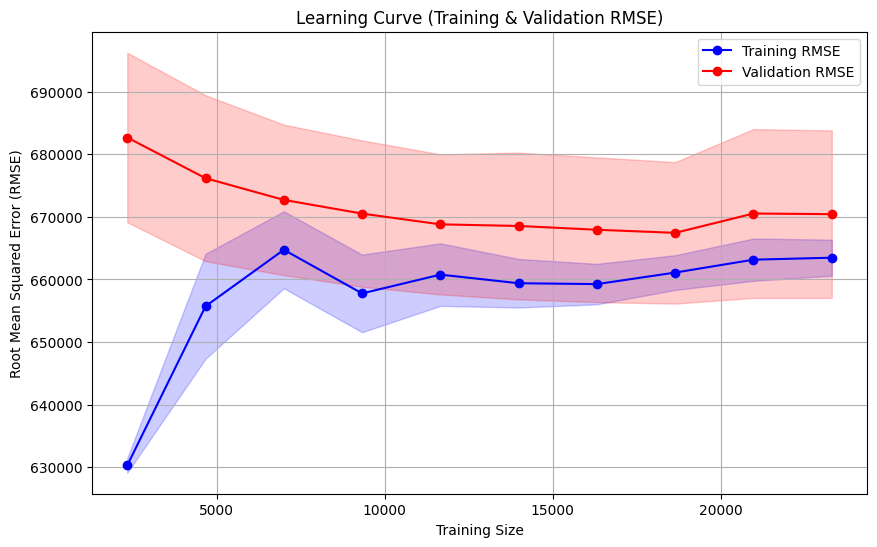

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Define the model
model = LinearRegression()

# Generate learning curves
train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Calculate mean and std deviation of training and validation scores
train_mean = -train_scores.mean(axis=1)  # Negative sign because 'learning_curve' uses negative MSE
val_mean = -val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)

# Convert MSE to RMSE by taking the square root
train_rmse_mean = np.sqrt(train_mean)
val_rmse_mean = np.sqrt(val_mean)
train_rmse_std = train_std / (2 * np.sqrt(train_mean))  # Approximate RMSE standard deviation
val_rmse_std = val_std / (2 * np.sqrt(val_mean))  # Approximate RMSE standard deviation

# Plot learning curve (RMSE)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_rmse_mean, label="Training RMSE", color="blue", marker="o")
plt.plot(train_sizes, val_rmse_mean, label="Validation RMSE", color="red", marker="o")
plt.fill_between(train_sizes, train_rmse_mean - train_rmse_std, train_rmse_mean + train_rmse_std, color="blue", alpha=0.2)
plt.fill_between(train_sizes, val_rmse_mean - val_rmse_std, val_rmse_mean + val_rmse_std, color="red", alpha=0.2)

plt.title("Learning Curve (Training & Validation RMSE)")
plt.xlabel("Training Size")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.legend()
plt.grid(True)
plt.show()



* Both training and validation RMSE values fluctuate without significant improvement as more data is added, suggesting that the model is not learning effectively from the data.

* The consistently higher validation RMSE compared to training RMSE, along with little change in performance, indicates that the current model (Linear Regression) may be underfitting the data, meaning it's too simple to capture the underlying patterns.

### b) Random Forest

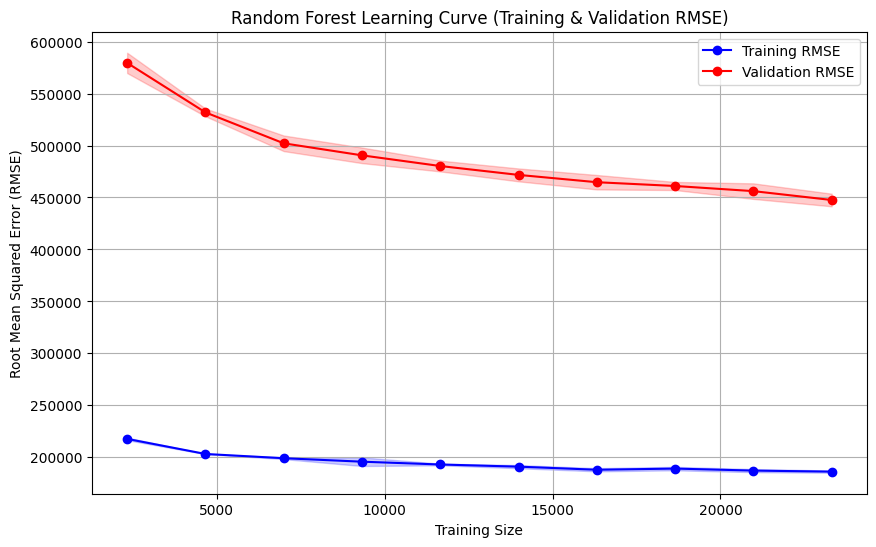

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Define the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=140,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features=None,
    max_depth=30,
    random_state=42
)

# Generate learning curves
train_sizes, train_scores, val_scores = learning_curve(rf_model, X_train, y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Calculate mean and std deviation of training and validation scores
train_mean = -train_scores.mean(axis=1)  # Negative sign because 'learning_curve' uses negative MSE
val_mean = -val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)

# Convert MSE to RMSE by taking the square root
train_rmse_mean = np.sqrt(train_mean)
val_rmse_mean = np.sqrt(val_mean)
train_rmse_std = train_std / (2 * np.sqrt(train_mean))  # Approximate RMSE standard deviation
val_rmse_std = val_std / (2 * np.sqrt(val_mean))  # Approximate RMSE standard deviation

# Plot learning curve (RMSE)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_rmse_mean, label="Training RMSE", color="blue", marker="o")
plt.plot(train_sizes, val_rmse_mean, label="Validation RMSE", color="red", marker="o")
plt.fill_between(train_sizes, train_rmse_mean - train_rmse_std, train_rmse_mean + train_rmse_std, color="blue", alpha=0.2)
plt.fill_between(train_sizes, val_rmse_mean - val_rmse_std, val_rmse_mean + val_rmse_std, color="red", alpha=0.2)

plt.title("Random Forest Learning Curve (Training & Validation RMSE)")
plt.xlabel("Training Size")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Print the training and validation RMSE data points

# Training RMSE data points
print("Training RMSE (Mean):")
for i, size in enumerate(train_sizes):
    print(f"Training Size: {size:.2f}, RMSE: {train_rmse_mean[i]:.4f}")

# Validation RMSE data points
print("\nValidation RMSE (Mean):")
for i, size in enumerate(train_sizes):
    print(f"Training Size: {size:.2f}, RMSE: {val_rmse_mean[i]:.4f}")


Training RMSE (Mean):
Training Size: 2331.00, RMSE: 217681.9656
Training Size: 4662.00, RMSE: 203177.9618
Training Size: 6993.00, RMSE: 199090.8486
Training Size: 9324.00, RMSE: 195752.6445
Training Size: 11655.00, RMSE: 193043.6797
Training Size: 13986.00, RMSE: 190972.5171
Training Size: 16317.00, RMSE: 187986.4778
Training Size: 18648.00, RMSE: 189107.5379
Training Size: 20979.00, RMSE: 187175.4763
Training Size: 23311.00, RMSE: 186185.5116

Validation RMSE (Mean):
Training Size: 2331.00, RMSE: 579516.5293
Training Size: 4662.00, RMSE: 531881.9462
Training Size: 6993.00, RMSE: 502124.3734
Training Size: 9324.00, RMSE: 490542.4362
Training Size: 11655.00, RMSE: 480264.3121
Training Size: 13986.00, RMSE: 471723.3315
Training Size: 16317.00, RMSE: 464687.0528
Training Size: 18648.00, RMSE: 461045.3165
Training Size: 20979.00, RMSE: 456106.0942
Training Size: 23311.00, RMSE: 447571.0604



- **Training RMSE** remains relatively low and decreases steadily as the training set size increases, indicating that the **Random Forest** model is fitting the training data very well. This behavior is typical for **Random Forest** models, which can capture complex patterns in the data, especially when provided with more samples.

- **Validation RMSE** decreases steadily as the training size increases, but it remains significantly higher than the training RMSE. This suggests that while the model performs well on the training set, it still has room for improvement in terms of generalizing to unseen data. The gap between the training and validation RMSE indicates that the model might be experiencing **overfitting**, especially when it performs better on the training data compared to the validation set.

- Despite the gap between training and validation RMSE, the **decreasing validation RMSE** as more data is introduced shows that the model benefits from **larger datasets**. This suggests that the model has a good potential for capturing the underlying complexity of the problem, as it improves its performance on unseen data as the training size grows.

- The **narrowing of the shaded areas** around the learning curves represents the **decreasing variance** in performance between different folds of the cross-validation. This indicates more **consistent performance** of the model across different training sizes, although the validation RMSE is still higher than the training RMSE.



### c) XGBoost

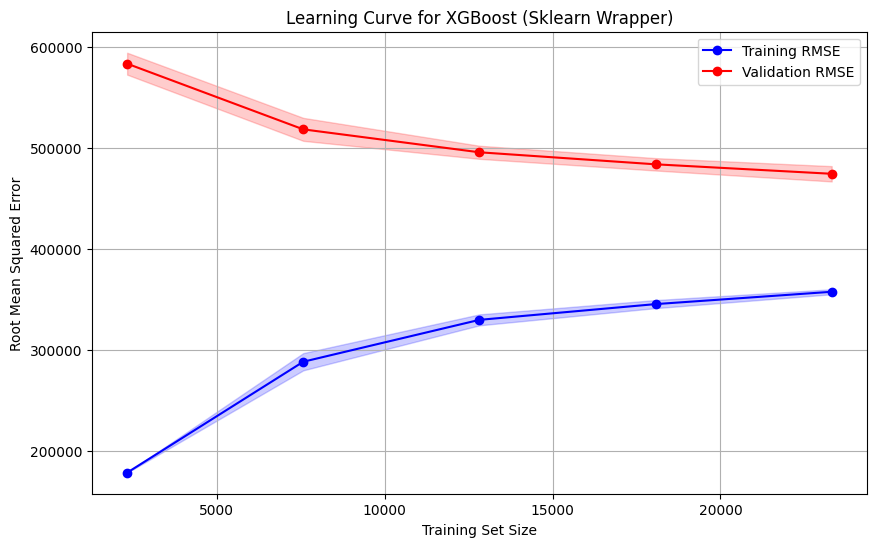

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor

# Custom wrapper for XGBoost
class XGBSklearnWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, **kwargs):
        self.model = XGBRegressor(**kwargs)

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

# Initialize the wrapped XGBoost model
wrapped_xgb = XGBSklearnWrapper(
    n_estimators=500,
    learning_rate=0.1,
    objective="reg:squarederror",
    verbosity=1
)

# Compute learning curve
train_sizes, train_scores, val_scores = learning_curve(
    wrapped_xgb,
    X_train,
    y_train,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

# Calculate mean and standard deviation for training and validation scores
train_mean = -np.mean(train_scores, axis=1)  # RMSE is negative in sklearn, so we negate it
train_std = np.std(train_scores, axis=1)
val_mean = -np.mean(val_scores, axis=1)  # RMSE is negative in sklearn, so we negate it
val_std = np.std(val_scores, axis=1)

# Plot learning curve for XGBoost
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training RMSE", color="blue", marker="o")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
plt.plot(train_sizes, val_mean, label="Validation RMSE", color="red", marker="o")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color="red")
plt.xlabel("Training Set Size")
plt.ylabel("Root Mean Squared Error")
plt.title("Learning Curve for XGBoost (Sklearn Wrapper)")
plt.legend()
plt.grid(True)
plt.show()





*  Training RMSE starts very low and increases as the training set size grows.
*  Validation RMSE decreases with larger datasets, though not as significantly as the Random Forest model.
* The steady decline in validation RMSE with more data indicates the model scales well and can handle larger datasets effectively.
* The gap between training and validation RMSE narrows with increased training size, suggesting better generalization with sufficient data.


